In [1]:
import pandas as pd
from pandas import DataFrame, to_datetime
import numpy as np
import os
import datetime, time
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import glob
import sqlite3

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

import scipy.stats as stats
from scipy.stats import boxcox
from math import sqrt

# Daten importieren und bereinigen

## Photovoltaik Anlagen laut Marktstammdatenregister bis Ende 2023

In [3]:
# alle EinheitenSolar Dateien als Gesamt-Tabelle einlesen.
filenames = glob.glob("../input/Marktstammdaten_2023/EinheitenSolar*.xml")
df = pd.concat(map(lambda file: pd.read_xml(file, encoding="utf-16", parser="lxml",
                                               dtype={"Gemeindeschluessel": str, "Postleitzahl": str}), filenames))
df

,EinheitMastrNummer,DatumLetzteAktualisierung,LokationMaStRNummer,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Land,Bundesland,Landkreis,Gemeinde,Gemeindeschluessel,...,DatumEndgueltigeStilllegung,InAnspruchGenommeneAckerflaeche,GenMastrNummer,Einsatzverantwortlicher,WeicDisplayName,DatumWiederaufnahmeBetrieb,GeplantesInbetriebnahmedatum,Buergerenergie,Kraftwerksnummer,Weic
0,SEE984033548619,2020-02-20T16:28:35.2508122,SEL948991715391,1,ABR949444220202,84,1409.0,Münster,Münster,05515000,...,None,NaN,None,NaN,None,None,None,NaN,None,NaN
1,SEE901901460125,2021-07-15T07:54:37.8637095,SEL982068309366,1,ABR930055871044,84,1402.0,Ostalbkreis,Schwäbisch Gmünd,08136065,...,None,NaN,None,NaN,None,None,None,NaN,None,NaN
2,SEE983679054270,2019-05-28T08:26:38.0316692,SEL906699064968,1,ABR983885950021,84,1400.0,Havelland,Nauen,12063208,...,None,NaN,None,NaN,None,None,None,NaN,None,NaN
3,SEE978732598938,2020-12-07T08:19:07.9860793,SEL996128012264,1,ABR980052996196,84,1403.0,Regensburg,Pentling,09375180,...,None,NaN,None,NaN,None,None,None,NaN,None,NaN
4,SEE970592691989,2021-01-25T11:18:30.0433603,SEL975715515692,1,ABR970373690446,84,1412.0,Saarlouis,Saarlouis,10044115,...,None,NaN,None,NaN,None,None,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,SEE912708828315,2021-10-29T09:20:14.5683829,SEL944300386719,0,ABR966043691738,84,1409.0,Hochsauerlandkreis,Meschede,05958032,...,None,NaN,None,NaN,NaN,None,None,NaN,None,NaN
99996,SEE901041552223,2021-02-14T15:38:01.4327855,SEL918128857140,1,ABR913758987366,84,1410.0,Germersheim,Ottersheim bei Landau,07334023,...,None,NaN,None,NaN,NaN,None,None,NaN,None,NaN
99997,SEE962435661280,2021-02-10T17:26:48.5896701,SEL985554817918,1,ABR929620895585,84,1408.0,Vechta,Visbek,03460010,...,None,NaN,None,NaN,NaN,None,None,NaN,None,NaN
99998,SEE921111558252,2021-09-20T07:47:38.3162711,SEL991499256071,1,ABR969563918507,84,1401.0,Berlin,Berlin,11000000,...,None,NaN,None,NaN,NaN,None,None,NaN,None,NaN


In [4]:
df_pv = df.copy()
df_pv.sort_values(by='Inbetriebnahmedatum', ascending=True, inplace=True)
df_pv.reset_index(drop=True,inplace=True)
df_pv

,EinheitMastrNummer,DatumLetzteAktualisierung,LokationMaStRNummer,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Land,Bundesland,Landkreis,Gemeinde,Gemeindeschluessel,...,DatumEndgueltigeStilllegung,InAnspruchGenommeneAckerflaeche,GenMastrNummer,Einsatzverantwortlicher,WeicDisplayName,DatumWiederaufnahmeBetrieb,GeplantesInbetriebnahmedatum,Buergerenergie,Kraftwerksnummer,Weic
0,SEE986622514685,2022-05-27T04:52:42.8017409,SEL948198410457,0,ABR913047449452,84,1402.0,Heilbronn,Gundelsheim,08125039,...,None,NaN,None,None,None,None,None,NaN,None,None
1,SEE905741857909,2022-04-19T04:41:31.4432018,SEL951432232197,0,ABR936947298111,84,1402.0,Alb-Donau-Kreis,Munderkingen,08425081,...,None,NaN,None,None,None,None,None,NaN,None,None
2,SEE999671313772,2022-04-27T04:52:08.3366695,SEL949613791625,0,ABR921411856409,84,1402.0,Hohenlohekreis,Bretzfeld,08126011,...,None,NaN,None,None,None,None,None,NaN,None,None
3,SEE944600278103,2023-12-16T10:28:06.8902189,SEL957952875111,0,ABR931879733778,84,1403.0,Landshut,Altdorf,09274113,...,None,NaN,None,None,None,None,None,NaN,None,None
4,SEE927263792339,2023-09-14T12:23:38.7978899,SEL926041615747,1,ABR900402284704,84,1411.0,Ostholstein,Oldenburg in Holstein,01055033,...,None,NaN,None,None,None,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733286,SEE905017477190,2020-04-28T13:58:16.9266172,None,0,ABR908609455057,84,1409.0,Köln,Köln,05315000,...,None,NaN,None,NaN,NaN,None,2020-05-15,NaN,None,NaN
3733287,SEE924316360460,2020-04-29T08:29:45.5229220,None,0,ABR905107621465,84,1407.0,Ludwigslust-Parchim,Parchim,13076108,...,None,NaN,None,NaN,NaN,None,2020-05-14,NaN,None,NaN
3733288,SEE942666271595,2020-04-29T10:14:17.9216311,None,0,ABR950899672003,84,1409.0,Steinfurt,Hörstel,05566016,...,None,NaN,None,NaN,NaN,None,2020-05-01,NaN,None,NaN
3733289,SEE964682983986,2020-05-05T12:23:45.0135843,None,0,ABR912463538597,84,1411.0,Herzogtum Lauenburg,Nusse,01053096,...,None,NaN,None,NaN,NaN,None,2020-05-06,NaN,None,NaN


In [5]:
# Welche Spalten weisen Nan-Values auf? 
nan_count = df_pv.isna().sum()
pd.set_option('display.max_rows', 100)
#print(nan_count )

In [6]:
# Count endgültig stillgelegte PV-Analgen
(df_pv.DatumEndgueltigeStilllegung).notnull().sum()

10989

In [7]:
# Design-Entscheidung: 10.989 endgültig stillgelegte PV-Anlagen aus dem Datensatz löschen
df_pv = df_pv[(df_pv.DatumEndgueltigeStilllegung).isnull()]
df_pv

,EinheitMastrNummer,DatumLetzteAktualisierung,LokationMaStRNummer,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Land,Bundesland,Landkreis,Gemeinde,Gemeindeschluessel,...,DatumEndgueltigeStilllegung,InAnspruchGenommeneAckerflaeche,GenMastrNummer,Einsatzverantwortlicher,WeicDisplayName,DatumWiederaufnahmeBetrieb,GeplantesInbetriebnahmedatum,Buergerenergie,Kraftwerksnummer,Weic
0,SEE986622514685,2022-05-27T04:52:42.8017409,SEL948198410457,0,ABR913047449452,84,1402.0,Heilbronn,Gundelsheim,08125039,...,None,NaN,None,None,None,None,None,NaN,None,None
1,SEE905741857909,2022-04-19T04:41:31.4432018,SEL951432232197,0,ABR936947298111,84,1402.0,Alb-Donau-Kreis,Munderkingen,08425081,...,None,NaN,None,None,None,None,None,NaN,None,None
2,SEE999671313772,2022-04-27T04:52:08.3366695,SEL949613791625,0,ABR921411856409,84,1402.0,Hohenlohekreis,Bretzfeld,08126011,...,None,NaN,None,None,None,None,None,NaN,None,None
3,SEE944600278103,2023-12-16T10:28:06.8902189,SEL957952875111,0,ABR931879733778,84,1403.0,Landshut,Altdorf,09274113,...,None,NaN,None,None,None,None,None,NaN,None,None
4,SEE927263792339,2023-09-14T12:23:38.7978899,SEL926041615747,1,ABR900402284704,84,1411.0,Ostholstein,Oldenburg in Holstein,01055033,...,None,NaN,None,None,None,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733286,SEE905017477190,2020-04-28T13:58:16.9266172,None,0,ABR908609455057,84,1409.0,Köln,Köln,05315000,...,None,NaN,None,NaN,NaN,None,2020-05-15,NaN,None,NaN
3733287,SEE924316360460,2020-04-29T08:29:45.5229220,None,0,ABR905107621465,84,1407.0,Ludwigslust-Parchim,Parchim,13076108,...,None,NaN,None,NaN,NaN,None,2020-05-14,NaN,None,NaN
3733288,SEE942666271595,2020-04-29T10:14:17.9216311,None,0,ABR950899672003,84,1409.0,Steinfurt,Hörstel,05566016,...,None,NaN,None,NaN,NaN,None,2020-05-01,NaN,None,NaN
3733289,SEE964682983986,2020-05-05T12:23:45.0135843,None,0,ABR912463538597,84,1411.0,Herzogtum Lauenburg,Nusse,01053096,...,None,NaN,None,NaN,NaN,None,2020-05-06,NaN,None,NaN


In [8]:
# Sind alle aufgeführten PV-Anlagen in Deutschland? (Ländercode: 84)
df_pv.groupby('Land').count()

,EinheitMastrNummer,DatumLetzteAktualisierung,LokationMaStRNummer,NetzbetreiberpruefungStatus,AnlagenbetreiberMastrNummer,Bundesland,Landkreis,Gemeinde,Gemeindeschluessel,Postleitzahl,...,DatumEndgueltigeStilllegung,InAnspruchGenommeneAckerflaeche,GenMastrNummer,Einsatzverantwortlicher,WeicDisplayName,DatumWiederaufnahmeBetrieb,GeplantesInbetriebnahmedatum,Buergerenergie,Kraftwerksnummer,Weic
Land,,,,,,,,,,,,,,,,,,,,,
66,4,4,2,4,4,0,0,0,0,4,...,0,0,0,0,0,0,2,0,0,0
84,3722272,3722272,3663382,3722272,3722272,3722270,3722270,3722270,3722270,3722270,...,0,2874,1263,303,23,679,58109,1426,22,11
90,9,9,8,9,9,0,0,0,0,9,...,0,5,0,0,0,0,1,0,0,0
198,2,2,1,2,2,0,0,0,0,2,...,0,0,0,0,0,0,1,0,0,0
206,10,10,6,10,10,0,0,0,0,10,...,0,0,0,0,0,0,3,0,0,0
231,5,5,4,5,5,0,0,0,0,5,...,0,0,0,0,0,0,1,0,0,0


30 der gelisteten PV-Anlagen befinden sich nicht in Deutschland.   
(Details zur Länder-Zuordung siehe Notebook 01_ETL_DWH_Marktstammdaten.ipynb)   

In [9]:
# Einträge außerhalb Deutschlands löschen
df_pv = df_pv[(df_pv["Land"] == 84)]
#df_pv

In [10]:
# Relevante Spalten auswählen
pv_raw = df_pv[['Registrierungsdatum', 'Inbetriebnahmedatum', 'AnlagenbetreiberMastrNummer', 'Bruttoleistung', 'Einspeisungsart', 'Lage']]
pv_raw

,Registrierungsdatum,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2020-12-20,1900-01-01,ABR913047449452,4.80,688.0,853.0
1,2021-01-24,1900-01-01,ABR936947298111,1.80,688.0,853.0
2,2020-12-08,1900-01-01,ABR921411856409,2.31,688.0,853.0
3,2023-08-22,1900-01-01,ABR931879733778,0.60,689.0,2961.0
4,2023-09-14,1900-01-01,ABR900402284704,4.10,689.0,853.0
...,...,...,...,...,...,...
3733286,2020-04-28,None,ABR908609455057,7.20,689.0,853.0
3733287,2020-04-29,None,ABR905107621465,3.84,689.0,852.0
3733288,2020-04-29,None,ABR950899672003,7.68,689.0,853.0
3733289,2020-05-05,None,ABR912463538597,3.90,689.0,853.0


In [11]:
pv_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3722272 entries, 0 to 3733290
Data columns (total 6 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Registrierungsdatum          object 
 1   Inbetriebnahmedatum          object 
 2   AnlagenbetreiberMastrNummer  object 
 3   Bruttoleistung               float64
 4   Einspeisungsart              float64
 5   Lage                         float64
dtypes: float64(3), object(3)
memory usage: 198.8+ MB


In [12]:
# Welche Spalten weisen Nan-Values auf? 
nan_count = pv_raw.isna().sum()
pd.set_option('display.max_rows', 100)
print(nan_count )

Registrierungsdatum                0
Inbetriebnahmedatum            59034
AnlagenbetreiberMastrNummer        0
Bruttoleistung                     0
Einspeisungsart                25298
Lage                              56
dtype: int64


### Fehlende Werte: Inbetriebnahmedatum

In [13]:
# fehlende Werte mit dem Registrierungsdatum ersetzen
pv_raw.loc[pd.isnull(pv_raw['Inbetriebnahmedatum']), 'Inbetriebnahmedatum'] = pv_raw['Registrierungsdatum']

In [14]:
# Datumsangaben vor 2000 mit dem 01.01.2000 ersetzen
start_date = pd.to_datetime('2000-01-01')

pv_raw['Inbetriebnahmedatum'] = pd.to_datetime(pv_raw['Inbetriebnahmedatum'], errors='coerce')
pv_raw.loc[pv_raw['Inbetriebnahmedatum'].dt.year < 2000, 'Inbetriebnahmedatum'] = start_date
pv_raw

C:\Users\Conny\AppData\Local\Temp\ipykernel_2872\305977150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_raw['Inbetriebnahmedatum'] = pd.to_datetime(pv_raw['Inbetriebnahmedatum'], errors='coerce')


,Registrierungsdatum,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2020-12-20,2000-01-01,ABR913047449452,4.80,688.0,853.0
1,2021-01-24,2000-01-01,ABR936947298111,1.80,688.0,853.0
2,2020-12-08,2000-01-01,ABR921411856409,2.31,688.0,853.0
3,2023-08-22,2000-01-01,ABR931879733778,0.60,689.0,2961.0
4,2023-09-14,2000-01-01,ABR900402284704,4.10,689.0,853.0
...,...,...,...,...,...,...
3733286,2020-04-28,2020-04-28,ABR908609455057,7.20,689.0,853.0
3733287,2020-04-29,2020-04-29,ABR905107621465,3.84,689.0,852.0
3733288,2020-04-29,2020-04-29,ABR950899672003,7.68,689.0,853.0
3733289,2020-05-05,2020-05-05,ABR912463538597,3.90,689.0,853.0


In [15]:
pv_raw = pv_raw[pv_raw['Inbetriebnahmedatum'].dt.year != 2024]
pv_raw

,Registrierungsdatum,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2020-12-20,2000-01-01,ABR913047449452,4.80,688.0,853.0
1,2021-01-24,2000-01-01,ABR936947298111,1.80,688.0,853.0
2,2020-12-08,2000-01-01,ABR921411856409,2.31,688.0,853.0
3,2023-08-22,2000-01-01,ABR931879733778,0.60,689.0,2961.0
4,2023-09-14,2000-01-01,ABR900402284704,4.10,689.0,853.0
...,...,...,...,...,...,...
3733286,2020-04-28,2020-04-28,ABR908609455057,7.20,689.0,853.0
3733287,2020-04-29,2020-04-29,ABR905107621465,3.84,689.0,852.0
3733288,2020-04-29,2020-04-29,ABR950899672003,7.68,689.0,853.0
3733289,2020-05-05,2020-05-05,ABR912463538597,3.90,689.0,853.0


In [16]:
pv_raw.sort_values(by='Inbetriebnahmedatum', ascending=True, inplace=True)
pv_raw.reset_index(drop=True,inplace=True)
pv_raw

C:\Users\Conny\AppData\Local\Temp\ipykernel_2872\2425620336.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_raw.sort_values(by='Inbetriebnahmedatum', ascending=True, inplace=True)


,Registrierungsdatum,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2020-12-20,2000-01-01,ABR913047449452,4.800,688.0,853.0
1,2020-11-04,2000-01-01,ABR927983195809,1.800,688.0,853.0
2,2021-01-01,2000-01-01,ABR967497165592,3.600,NaN,853.0
3,2020-06-05,2000-01-01,ABR995277554304,2.025,688.0,853.0
4,2021-01-20,2000-01-01,ABR928317589493,4.500,689.0,853.0
...,...,...,...,...,...,...
3722262,2023-12-31,2023-12-31,ABR932413982492,0.600,689.0,2961.0
3722263,2023-12-31,2023-12-31,ABR976144407114,10.200,689.0,853.0
3722264,2023-12-31,2023-12-31,ABR964771367109,0.800,689.0,2961.0
3722265,2023-12-31,2023-12-31,ABR974622299794,0.780,689.0,2961.0


In [17]:
# Spalte Registrierdatum löschen
pv_raw.drop('Registrierungsdatum', axis=1, inplace=True)
pv_raw

C:\Users\Conny\AppData\Local\Temp\ipykernel_2872\4236354915.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_raw.drop('Registrierungsdatum', axis=1, inplace=True)


,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01,ABR913047449452,4.800,688.0,853.0
1,2000-01-01,ABR927983195809,1.800,688.0,853.0
2,2000-01-01,ABR967497165592,3.600,NaN,853.0
3,2000-01-01,ABR995277554304,2.025,688.0,853.0
4,2000-01-01,ABR928317589493,4.500,689.0,853.0
...,...,...,...,...,...
3722262,2023-12-31,ABR932413982492,0.600,689.0,2961.0
3722263,2023-12-31,ABR976144407114,10.200,689.0,853.0
3722264,2023-12-31,ABR964771367109,0.800,689.0,2961.0
3722265,2023-12-31,ABR974622299794,0.780,689.0,2961.0


### Fehlende Werte: Einspeisungsart

In [18]:
# Codierung Einspeisungsart ändern:
# Voll für Volleinspeisung (688)
# Teil für Teileinspeisung (689)
pv_raw['Einspeisungsart'] = pv_raw['Einspeisungsart'].apply(lambda x: 'Teil' if x == 689.0 else ('Voll' if x == 688.0 else x))
pv_raw.reset_index(drop=True,inplace=True)
pv_raw

C:\Users\Conny\AppData\Local\Temp\ipykernel_2872\2744245857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_raw['Einspeisungsart'] = pv_raw['Einspeisungsart'].apply(lambda x: 'Teil' if x == 689.0 else ('Voll' if x == 688.0 else x))


,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01,ABR913047449452,4.800,Voll,853.0
1,2000-01-01,ABR927983195809,1.800,Voll,853.0
2,2000-01-01,ABR967497165592,3.600,NaN,853.0
3,2000-01-01,ABR995277554304,2.025,Voll,853.0
4,2000-01-01,ABR928317589493,4.500,Teil,853.0
...,...,...,...,...,...
3722262,2023-12-31,ABR932413982492,0.600,Teil,2961.0
3722263,2023-12-31,ABR976144407114,10.200,Teil,853.0
3722264,2023-12-31,ABR964771367109,0.800,Teil,2961.0
3722265,2023-12-31,ABR974622299794,0.780,Teil,2961.0


In [19]:
pv_raw = pv_raw.copy()
pv_raw['Inbetriebnahmedatum'] = pd.to_datetime(pv_raw['Inbetriebnahmedatum'], errors='coerce')

before_2013 = pv_raw['Inbetriebnahmedatum'].dt.year <= 2012
pv_raw.loc[before_2013 & pv_raw['Einspeisungsart'].isnull(), 'Einspeisungsart'] = 'Voll'

after_2012 = pv_raw['Inbetriebnahmedatum'].dt.year > 2012
pv_raw.loc[after_2012 & pv_raw['Einspeisungsart'].isnull(), 'Einspeisungsart'] = 'Teil'
pv_raw

,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01,ABR913047449452,4.800,Voll,853.0
1,2000-01-01,ABR927983195809,1.800,Voll,853.0
2,2000-01-01,ABR967497165592,3.600,Voll,853.0
3,2000-01-01,ABR995277554304,2.025,Voll,853.0
4,2000-01-01,ABR928317589493,4.500,Teil,853.0
...,...,...,...,...,...
3722262,2023-12-31,ABR932413982492,0.600,Teil,2961.0
3722263,2023-12-31,ABR976144407114,10.200,Teil,853.0
3722264,2023-12-31,ABR964771367109,0.800,Teil,2961.0
3722265,2023-12-31,ABR974622299794,0.780,Teil,2961.0


In [20]:
pv_raw.sort_index(inplace=True)
pv_raw

,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01,ABR913047449452,4.800,Voll,853.0
1,2000-01-01,ABR927983195809,1.800,Voll,853.0
2,2000-01-01,ABR967497165592,3.600,Voll,853.0
3,2000-01-01,ABR995277554304,2.025,Voll,853.0
4,2000-01-01,ABR928317589493,4.500,Teil,853.0
...,...,...,...,...,...
3722262,2023-12-31,ABR932413982492,0.600,Teil,2961.0
3722263,2023-12-31,ABR976144407114,10.200,Teil,853.0
3722264,2023-12-31,ABR964771367109,0.800,Teil,2961.0
3722265,2023-12-31,ABR974622299794,0.780,Teil,2961.0


### Fehlende Werte: Lage

In [21]:
# die meisten PV-Anlagen sind in Haushalten installiert
# daher ersetzen der 56 fehlenden Werte mit 853 Bauliche Anlagen (Hausdach, Gebäude und Fassade)
pv_raw['Lage'].fillna(853, inplace=True)
pv_raw

,Inbetriebnahmedatum,AnlagenbetreiberMastrNummer,Bruttoleistung,Einspeisungsart,Lage
0,2000-01-01,ABR913047449452,4.800,Voll,853.0
1,2000-01-01,ABR927983195809,1.800,Voll,853.0
2,2000-01-01,ABR967497165592,3.600,Voll,853.0
3,2000-01-01,ABR995277554304,2.025,Voll,853.0
4,2000-01-01,ABR928317589493,4.500,Teil,853.0
...,...,...,...,...,...
3722262,2023-12-31,ABR932413982492,0.600,Teil,2961.0
3722263,2023-12-31,ABR976144407114,10.200,Teil,853.0
3722264,2023-12-31,ABR964771367109,0.800,Teil,2961.0
3722265,2023-12-31,ABR974622299794,0.780,Teil,2961.0


In [22]:
# Welche Spalten weisen Nan-Values auf? 
nan_count = pv_raw.isna().sum()
print(nan_count )

Inbetriebnahmedatum            0
AnlagenbetreiberMastrNummer    0
Bruttoleistung                 0
Einspeisungsart                0
Lage                           0
dtype: int64


### Export in SQLite Datenbank

In [23]:
# SQLite Datenbank Pfad 
SQLITE_FILE_PATH = os.path.join("..", "output", "dwh.sqlite3")

In [24]:
# Connection zur Datenbank 
con = sqlite3.connect(SQLITE_FILE_PATH)

In [25]:
# Marktstammdaten-Tabelle anlegen
pv_raw.to_sql("marktstammdaten_2023", con=con, if_exists="replace", index=False)

3722267

## Strompreise und EEG-Vergütung

In [26]:
# Datenbank-Abfrage
query_01 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN 1 ELSE 0 END) AS Anzahl_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN 1 ELSE 0 END) AS Anzahl_Teileinspeisung,
    AVG(e.Einspeiseverguetung_kleine_PV_Anlagen) AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis
FROM
    marktstammdaten_2023 m
LEFT JOIN
    einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN
    strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
GROUP BY
    strftime('%Y-%m', m.Inbetriebnahmedatum)
ORDER BY
    Jahr_Monat;
    """
abfrage_01 = pd.read_sql_query(query_01, con=con)
abfrage_01

,Jahr_Monat,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis
0,2000-01,6944,2620,50.62,14.92
1,2000-02,99,25,50.62,14.92
2,2000-03,163,21,50.62,14.92
3,2000-04,871,153,50.62,14.92
4,2000-05,709,162,50.62,14.92
...,...,...,...,...,...
283,2023-08,3807,98267,7.65,46.27
284,2023-09,3443,89448,7.65,46.27
285,2023-10,3008,77553,7.65,46.27
286,2023-11,2221,66049,7.65,46.27


### Plot Voll-und Teileinspeisung (Monatsansicht)

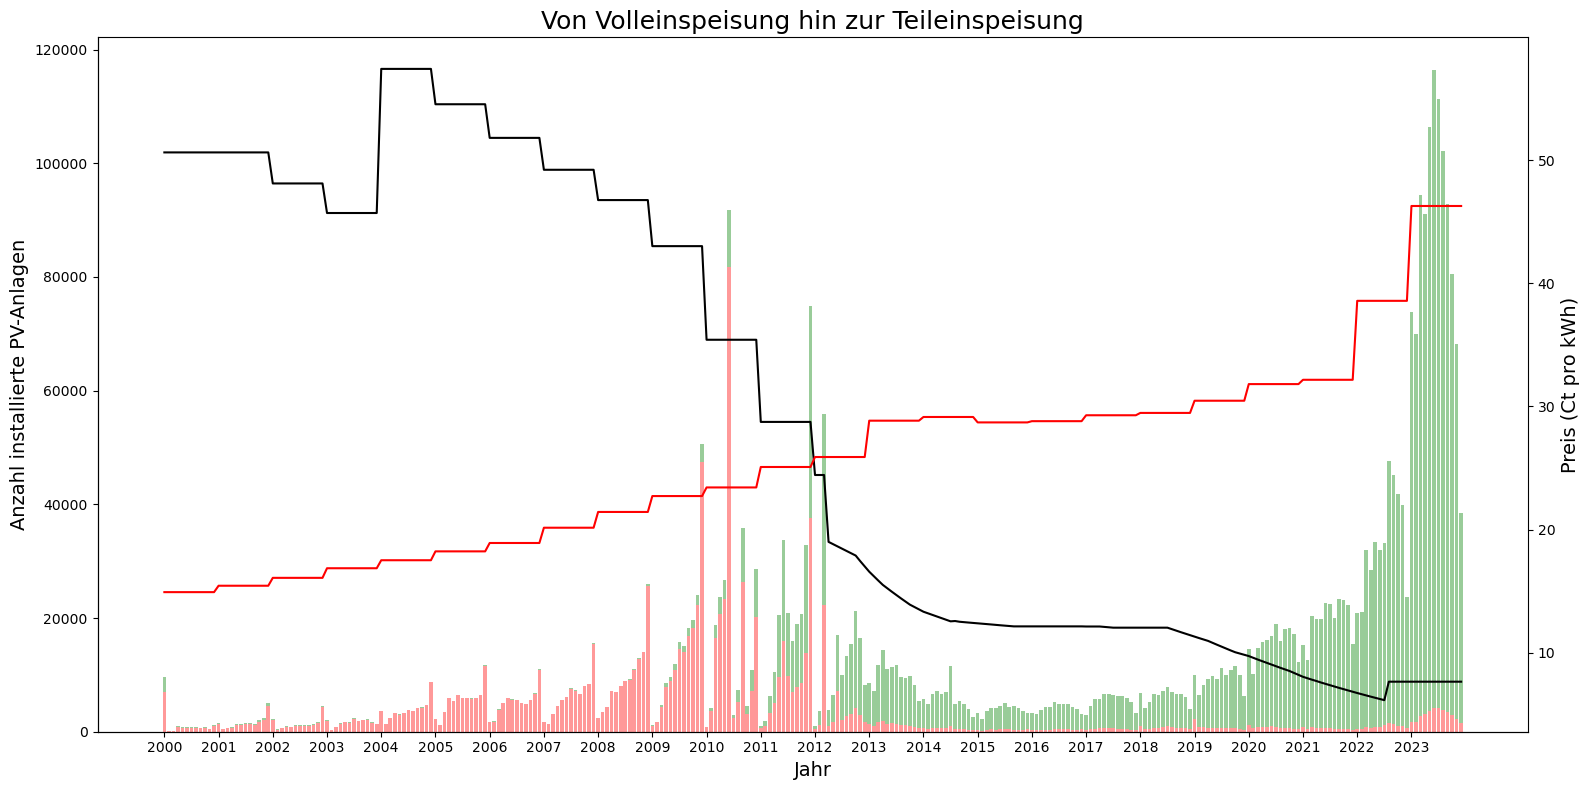

In [27]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.bar(abfrage_01['Jahr_Monat'], abfrage_01['Anzahl_Volleinspeisung'], 
        label='Anzahl_Volleinspeisung', width=0.8, color='red', alpha=0.4)
ax1.bar(abfrage_01['Jahr_Monat'], abfrage_01['Anzahl_Teileinspeisung'], 
        label='Anzahl_Teileinspeisung', width=0.8, color='green', alpha=0.4, bottom=abfrage_01['Anzahl_Volleinspeisung'])

ax2 = ax1.twinx()
ax2.plot(abfrage_01['Jahr_Monat'], abfrage_01['Einspeiseverguetung'], color='black', label='Einspeisevergütung')
ax2.plot(abfrage_01['Jahr_Monat'], abfrage_01['Strompreis'], color='red', label='Strompreis')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax1.set_xlabel('Jahr', fontsize=14)
ax1.set_ylabel('Anzahl installierte PV-Anlagen', fontsize=14)
ax2.set_ylabel('Preis (Ct pro kWh)', fontsize=14)

years = abfrage_01['Jahr_Monat'].apply(lambda x: int(x[:4]))
positions = range(0, len(abfrage_01), 12)
plt.xticks(positions, years.unique(), rotation=45)

plt.title('Von Volleinspeisung hin zur Teileinspeisung', fontsize=18)
plt.tight_layout()

plt.show()


### Plot Voll-und Teileinspeisung (Jahresansicht)

In [28]:
# Jahr aus der Spalte Jahr_Monat extrahieren
abfrage_01['Jahr'] = abfrage_01['Jahr_Monat'].str[:4]

# numerische Werte
abfrage_01['Einspeiseverguetung'] = pd.to_numeric(abfrage_01['Einspeiseverguetung'], errors='coerce')
abfrage_01['Strompreis'] = pd.to_numeric(abfrage_01['Strompreis'], errors='coerce')

# nach Jahr gruppieren
abfrage_01_jahr = abfrage_01.groupby('Jahr').agg({
    'Anzahl_Volleinspeisung': 'sum',
    'Anzahl_Teileinspeisung': 'sum',
    'Einspeiseverguetung': 'mean',
    'Strompreis': 'mean'
})
abfrage_01_jahr.reset_index(inplace=True)
abfrage_01_jahr

,Jahr,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis
0,2000,13646,3739,50.620000,14.92
1,2001,17960,2332,50.620000,15.44
2,2002,15917,1484,48.100000,16.08
3,2003,19154,316,45.700000,16.86
4,2004,46396,320,57.400000,17.51
5,2005,66204,489,54.530000,18.23
6,2006,62810,526,51.800000,18.91
7,2007,75667,604,49.210000,20.15
8,2008,113687,999,46.750000,21.43
9,2009,167962,13253,43.010000,22.72


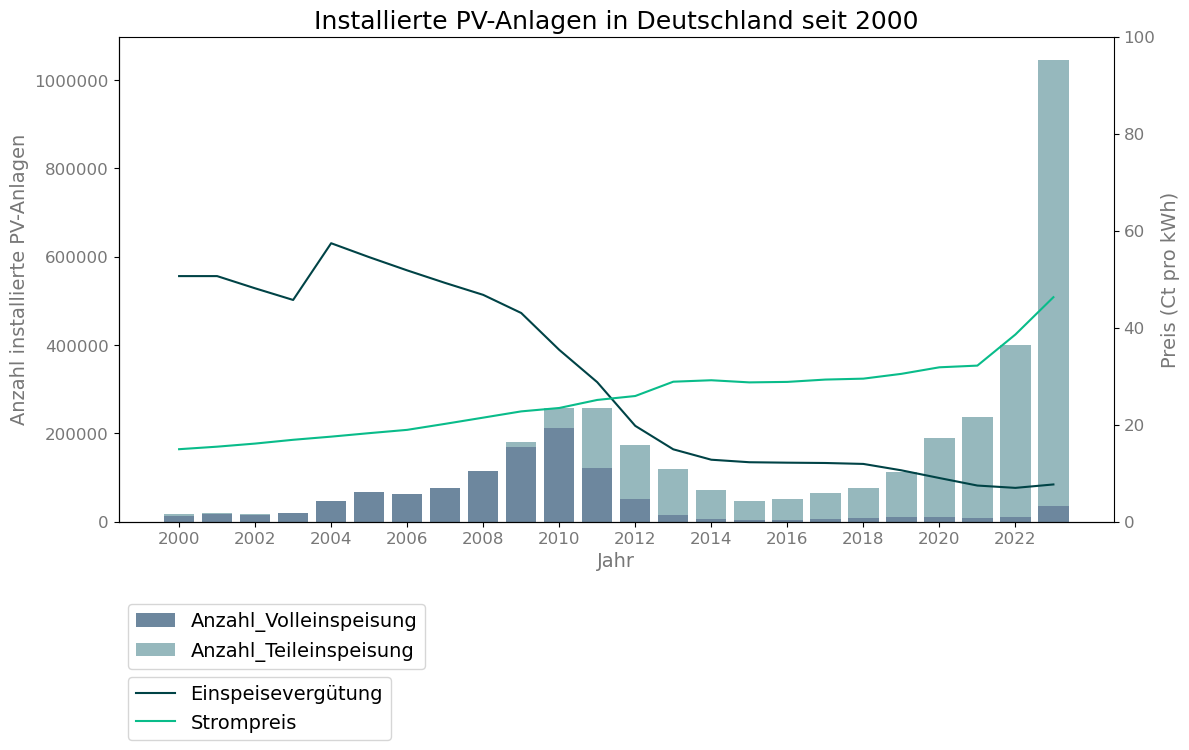

In [29]:
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(abfrage_01_jahr['Jahr'], abfrage_01_jahr['Anzahl_Volleinspeisung'], 
        label='Anzahl_Volleinspeisung', width=0.8, color='#2F5575', alpha=0.7)
ax1.bar(abfrage_01_jahr['Jahr'], abfrage_01_jahr['Anzahl_Teileinspeisung'], 
        label='Anzahl_Teileinspeisung', width=0.8, color='#508991', alpha=0.6, bottom=abfrage_01_jahr['Anzahl_Volleinspeisung'])

ax2 = ax1.twinx()
ax2.plot(abfrage_01_jahr['Jahr'], abfrage_01_jahr['Einspeiseverguetung'], color='#004346', label='Einspeisevergütung')
ax2.plot(abfrage_01_jahr['Jahr'], abfrage_01_jahr['Strompreis'], color='#09bc8a', label='Strompreis')

plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

ax1.set_xlabel('Jahr', fontsize=14, color='#777777')
ax1.set_ylabel('Anzahl installierte PV-Anlagen', fontsize=14, color='#777777')
ax1.ticklabel_format(style='plain', axis='y')  
ax1.tick_params(axis='both', which='major', labelsize=12)
for label in ax1.get_xticklabels() + ax1.get_yticklabels():
    label.set_color('#777777')

ax2.set_ylabel('Preis (Ct pro kWh)', fontsize=14, color='#777777')
ax2.set_ylim([0, 100])
ax2.tick_params(axis='both', which='major', labelsize=12)
for label in ax2.get_xticklabels() + ax2.get_yticklabels():
    label.set_color('#777777')

years = abfrage_01_jahr['Jahr']
positions = range(0, len(abfrage_01_jahr), 2) 
labels = [years[i] for i in positions] 
plt.xticks(positions, labels, rotation=45)  

# Legenden anzeigen
ax1.legend(loc='upper left', bbox_to_anchor=(0.0, -0.15), ncol=1, fontsize=14) 
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, -0.30), ncol=1, fontsize=14) 

plt.title('Installierte PV-Anlagen in Deutschland seit 2000', fontsize=18)
plt.tight_layout()

plt.show()

# Zeitreihen-Analysen & Modell Evaluation

## Vorbereitung der Daten

In [30]:
# Datenbank-Abfrage
query_02 = """
SELECT
    strftime('%Y-%m', m.Inbetriebnahmedatum) AS Jahr_Monat,
    SUM(m.Bruttoleistung) AS GesamtBruttoleistung,
    SUM(CASE WHEN m.Einspeisungsart = 'Voll' THEN 1 ELSE 0 END) AS Anzahl_Volleinspeisung,
    SUM(CASE WHEN m.Einspeisungsart = 'Teil' THEN 1 ELSE 0 END) AS Anzahl_Teileinspeisung,
    AVG(e.Einspeiseverguetung_kleine_PV_Anlagen) AS Einspeiseverguetung,
    MAX(s.Strom_Verbraucherpreis) AS Strompreis
FROM
    marktstammdaten_2023 m
LEFT JOIN
    einspeiseverguetung e ON m.Inbetriebnahmedatum = e.Datum
LEFT JOIN
    strompreis s ON strftime('%Y', m.Inbetriebnahmedatum) = s.Jahr
GROUP BY
    strftime('%Y-%m', m.Inbetriebnahmedatum)
ORDER BY
    Jahr_Monat;
    """
abfrage_02 = pd.read_sql_query(query_02, con=con)
abfrage_02

,Jahr_Monat,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis
0,2000-01,42308.897,6944,2620,50.62,14.92
1,2000-02,757.749,99,25,50.62,14.92
2,2000-03,698.163,163,21,50.62,14.92
3,2000-04,3479.965,871,153,50.62,14.92
4,2000-05,3285.015,709,162,50.62,14.92
...,...,...,...,...,...,...
283,2023-08,2304090.367,3807,98267,7.65,46.27
284,2023-09,1358857.379,3443,89448,7.65,46.27
285,2023-10,2101186.830,3008,77553,7.65,46.27
286,2023-11,1581038.041,2221,66049,7.65,46.27


In [31]:
# Daten zur EEG-Umlage einlesen
# Quellen:
# https://de.statista.com/statistik/daten/studie/152973/umfrage/eeg-umlage-entwicklung-der-strompreise-in-deutschland-seit-2000/
# https://www.enercity.de/magazin/unsere-welt/was-ist-die-eeg-umlage
# https://www.rewag.de/aktuelle-marktlage/eeg-umlage#group3578

eeg_umlage = pd.read_excel("../input/Data/eeg-umlage-fuer-haushaltsstromkunden.xlsx", sheet_name="Daten", index_col=0)
eeg_umlage

,Euro-Cent pro kWh
Datum,
2000-01-01,0.2
2000-02-01,0.2
2000-03-01,0.2
2000-04-01,0.2
2000-05-01,0.2
...,...
2023-08-01,0.0
2023-09-01,0.0
2023-10-01,0.0


In [32]:
# Mergen mit Haupttabelle
eeg_umlage = eeg_umlage.rename(columns={'Euro-Cent pro kWh': 'EEG_Umlage'})
eeg_umlage.index = pd.to_datetime(eeg_umlage.index)
abfrage_02['Jahr_Monat'] = pd.to_datetime(abfrage_02['Jahr_Monat'])

solar_df = pd.merge(abfrage_02, eeg_umlage, left_on='Jahr_Monat', right_index=True)
solar_df

,Jahr_Monat,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage
0,2000-01-01,42308.897,6944,2620,50.62,14.92,0.2
1,2000-02-01,757.749,99,25,50.62,14.92,0.2
2,2000-03-01,698.163,163,21,50.62,14.92,0.2
3,2000-04-01,3479.965,871,153,50.62,14.92,0.2
4,2000-05-01,3285.015,709,162,50.62,14.92,0.2
...,...,...,...,...,...,...,...
283,2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0
284,2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0
285,2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0
286,2023-11-01,1581038.041,2221,66049,7.65,46.27,0.0


In [33]:
# Daten zur Entwicklung der PV-Kosten in Euro pro kWp (Netto-Preis bezogen auf eine 5kWp-Anlage)
# Quellen:
# https://www.tech-for-future.de/preisentwicklung-photovoltaik/
# Daten von 2000 bis 2005 interpoliert anhand der PV-Preisentwicklung in Amerika:
# https://ourworldindata.org/grapher/solar-pv-prices

pv_preise = pd.read_excel("../input/Data/preise_solarmodule_pro_jahr.xlsx", sheet_name="pv_daten", index_col=0)
pv_preise

,PV_Kosten_Euro_pro_kWp
Jahr_Monat,
2000-01-01,8100
2000-02-01,8100
2000-03-01,8100
2000-04-01,8100
2000-05-01,8100
...,...
2023-08-01,1250
2023-09-01,1250
2023-10-01,1250


In [34]:
# Mergen mit Hauptabelle
pv_preise.reset_index(inplace=True)  
solar_df = pd.merge(solar_df, pv_preise, left_on='Jahr_Monat', right_on='Jahr_Monat')
solar_df

,Jahr_Monat,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp
0,2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100
1,2000-02-01,757.749,99,25,50.62,14.92,0.2,8100
2,2000-03-01,698.163,163,21,50.62,14.92,0.2,8100
3,2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100
4,2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100
...,...,...,...,...,...,...,...,...
283,2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250
284,2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250
285,2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250
286,2023-11-01,1581038.041,2221,66049,7.65,46.27,0.0,1250


In [35]:
# Reihenfolge der Spalten anpassen
solar_df = solar_df[['Jahr_Monat', 'GesamtBruttoleistung', 'Anzahl_Volleinspeisung',
                               'Anzahl_Teileinspeisung', 'Einspeiseverguetung', 'Strompreis', 'EEG_Umlage', 'PV_Kosten_Euro_pro_kWp']]
# Spalte umbenennen
#solar_df.rename(columns={'EEG Umlage': 'EEG_Umlage'}, inplace=True)
#solar_df

In [36]:
timeseries_df = solar_df.copy()
timeseries_df.set_index('Jahr_Monat', inplace=True)
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2000-01-01 to 2023-12-01
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   GesamtBruttoleistung    288 non-null    float64
 1   Anzahl_Volleinspeisung  288 non-null    int64  
 2   Anzahl_Teileinspeisung  288 non-null    int64  
 3   Einspeiseverguetung     288 non-null    float64
 4   Strompreis              288 non-null    float64
 5   EEG_Umlage              288 non-null    float64
 6   PV_Kosten_Euro_pro_kWp  288 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 18.0 KB


In [37]:
timeseries_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp
Jahr_Monat,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100
...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250


## Explorative Datenanalyse

### Visualisierung der Zeitreihe

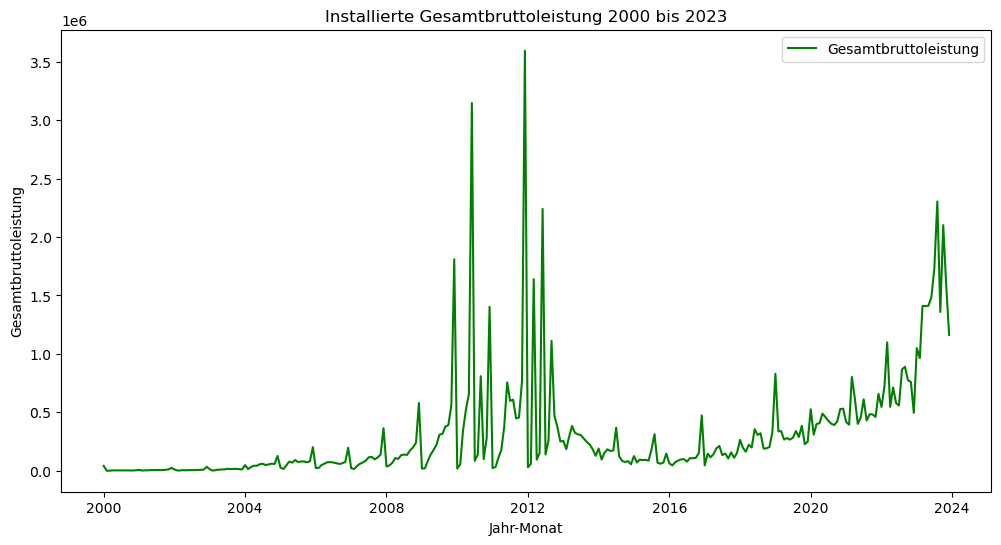

In [38]:
# Plot Gesamtbruttoleistung
plt.figure(figsize=(12, 6))
plt.plot(timeseries_df['GesamtBruttoleistung'], label='Gesamtbruttoleistung', color='green')
plt.title('Installierte Gesamtbruttoleistung 2000 bis 2023')
plt.xlabel('Jahr-Monat')
plt.ylabel('Gesamtbruttoleistung')
plt.legend()
plt.show()

### Korrelationsmatrix

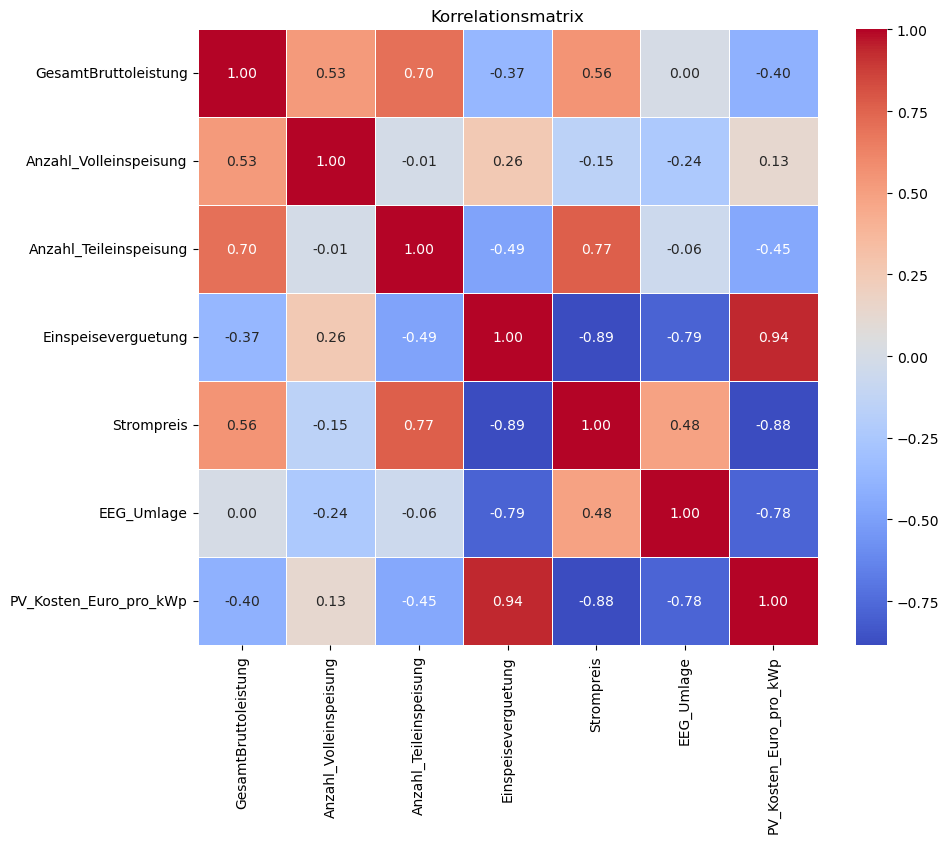

In [39]:
correlation_matrix = timeseries_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Korrelationsmatrix')
plt.show()

In [40]:
# Filtere die hoch korrelierten Werte (Korrelation >= 0.4)
high_correlation = correlation_matrix[correlation_matrix >= 0.4]
high_correlation = high_correlation.unstack().sort_values(ascending=False).drop_duplicates()
high_correlation = high_correlation[high_correlation >= 0.4]

print("Am höchsten korrelierte Variablen ab Korrelation 0,4:")
print(high_correlation)

Am höchsten korrelierte Variablen ab Korrelation 0,4:
GesamtBruttoleistung    GesamtBruttoleistung      1.000000
Einspeiseverguetung     PV_Kosten_Euro_pro_kWp    0.938985
Anzahl_Teileinspeisung  Strompreis                0.769324
                        GesamtBruttoleistung      0.704666
Strompreis              GesamtBruttoleistung      0.557166
Anzahl_Volleinspeisung  GesamtBruttoleistung      0.527788
Strompreis              EEG_Umlage                0.484659
dtype: float64


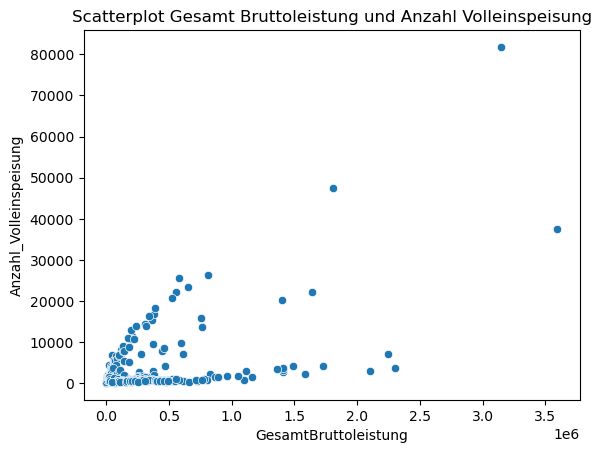

In [41]:
sns.scatterplot(x=timeseries_df['GesamtBruttoleistung'], y=timeseries_df['Anzahl_Volleinspeisung'])
plt.title('Scatterplot Gesamt Bruttoleistung und Anzahl Volleinspeisung')
plt.show()

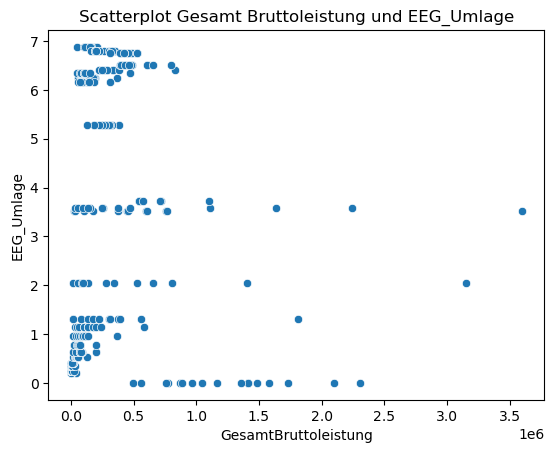

In [42]:
sns.scatterplot(x=timeseries_df['GesamtBruttoleistung'], y=timeseries_df['EEG_Umlage'])
plt.title('Scatterplot Gesamt Bruttoleistung und EEG_Umlage')
plt.show()

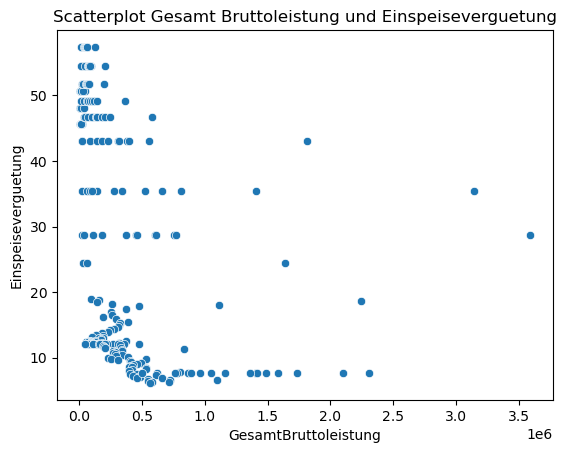

In [43]:
sns.scatterplot(x=timeseries_df['GesamtBruttoleistung'], y=timeseries_df['Einspeiseverguetung'])
plt.title('Scatterplot Gesamt Bruttoleistung und Einspeiseverguetung')
plt.show() 

### Saisonalität
Quelle: https://towardsdatascience.com/time-series-analysis-with-statsmodels-12309890539a   

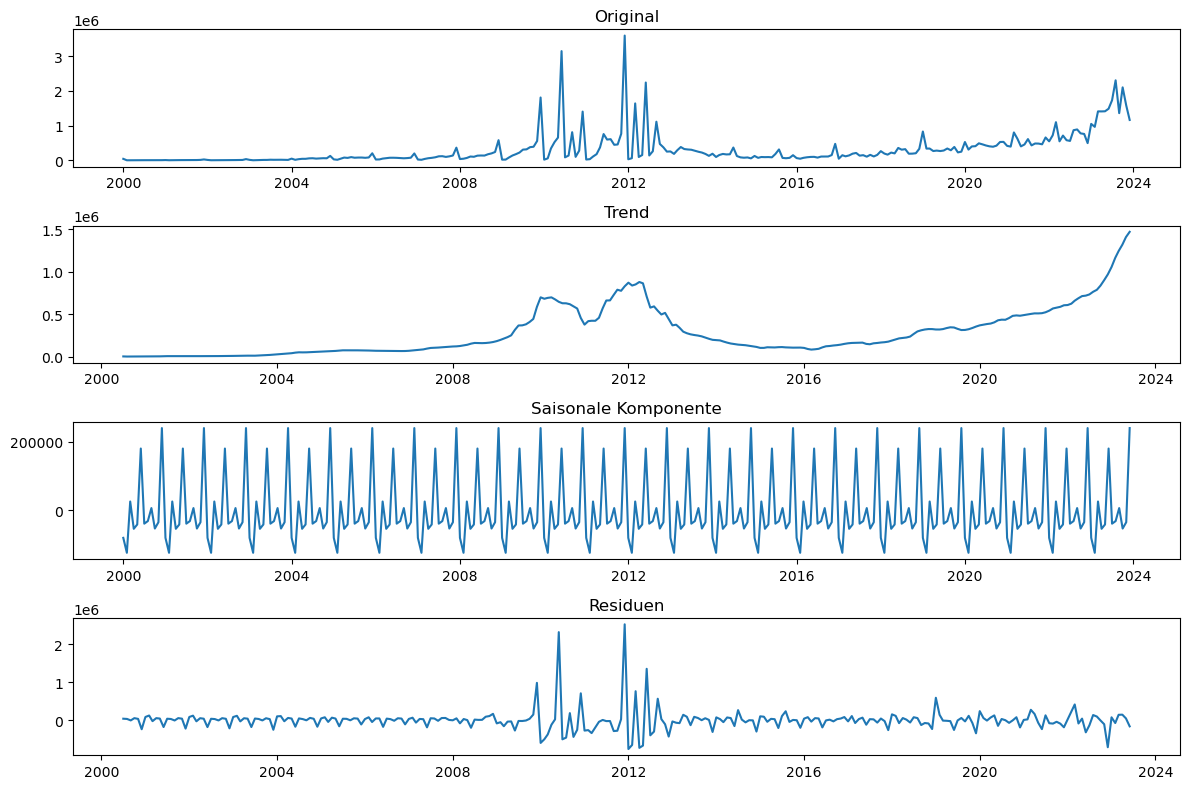

In [44]:
# Saisonale Zerlegung
# Additiv: anwendbar, wenn die Trend- und Saisonkomponenten im Zeitverlauf konstant (oder linear) sind.

result = seasonal_decompose(timeseries_df['GesamtBruttoleistung'], model='additive', period=12) 

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Original')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Saisonale Komponente')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residuen')

plt.tight_layout()
plt.show()

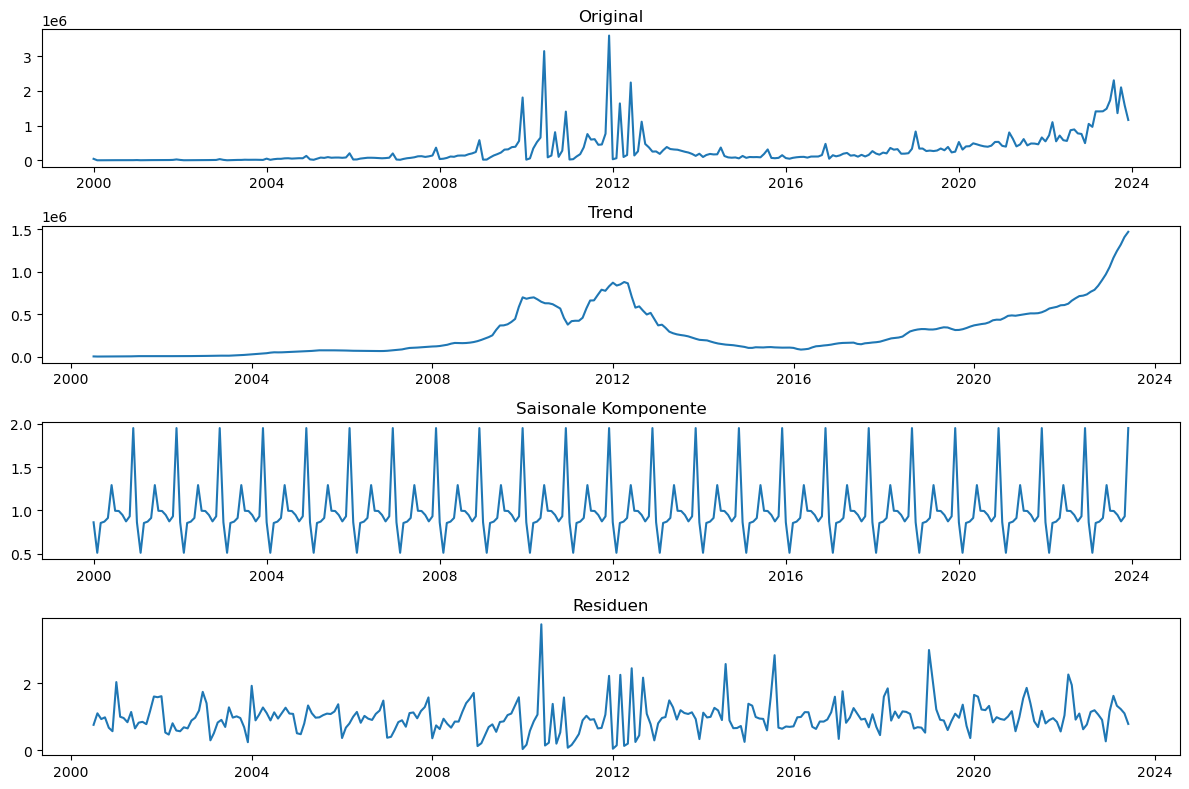

In [45]:
# Saisonale Zerlegung
# Multiplikativ: Anwendbar, wenn der Trend zu- oder abnehmend mit einer nicht linearen Rate ist.

result = seasonal_decompose(timeseries_df['GesamtBruttoleistung'], model='multiplicative', period=12) 

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title('Original')

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Saisonale Komponente')

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residuen')

plt.tight_layout()
plt.show()

Das multiplikative Modell passt etwas besser zu den Daten. Die Residuen sind gleichmäßiger verteilt über die Zeitachse hinweg und zeigen weniger extreme Ausschläge.

### Visualisierung der Verteilung

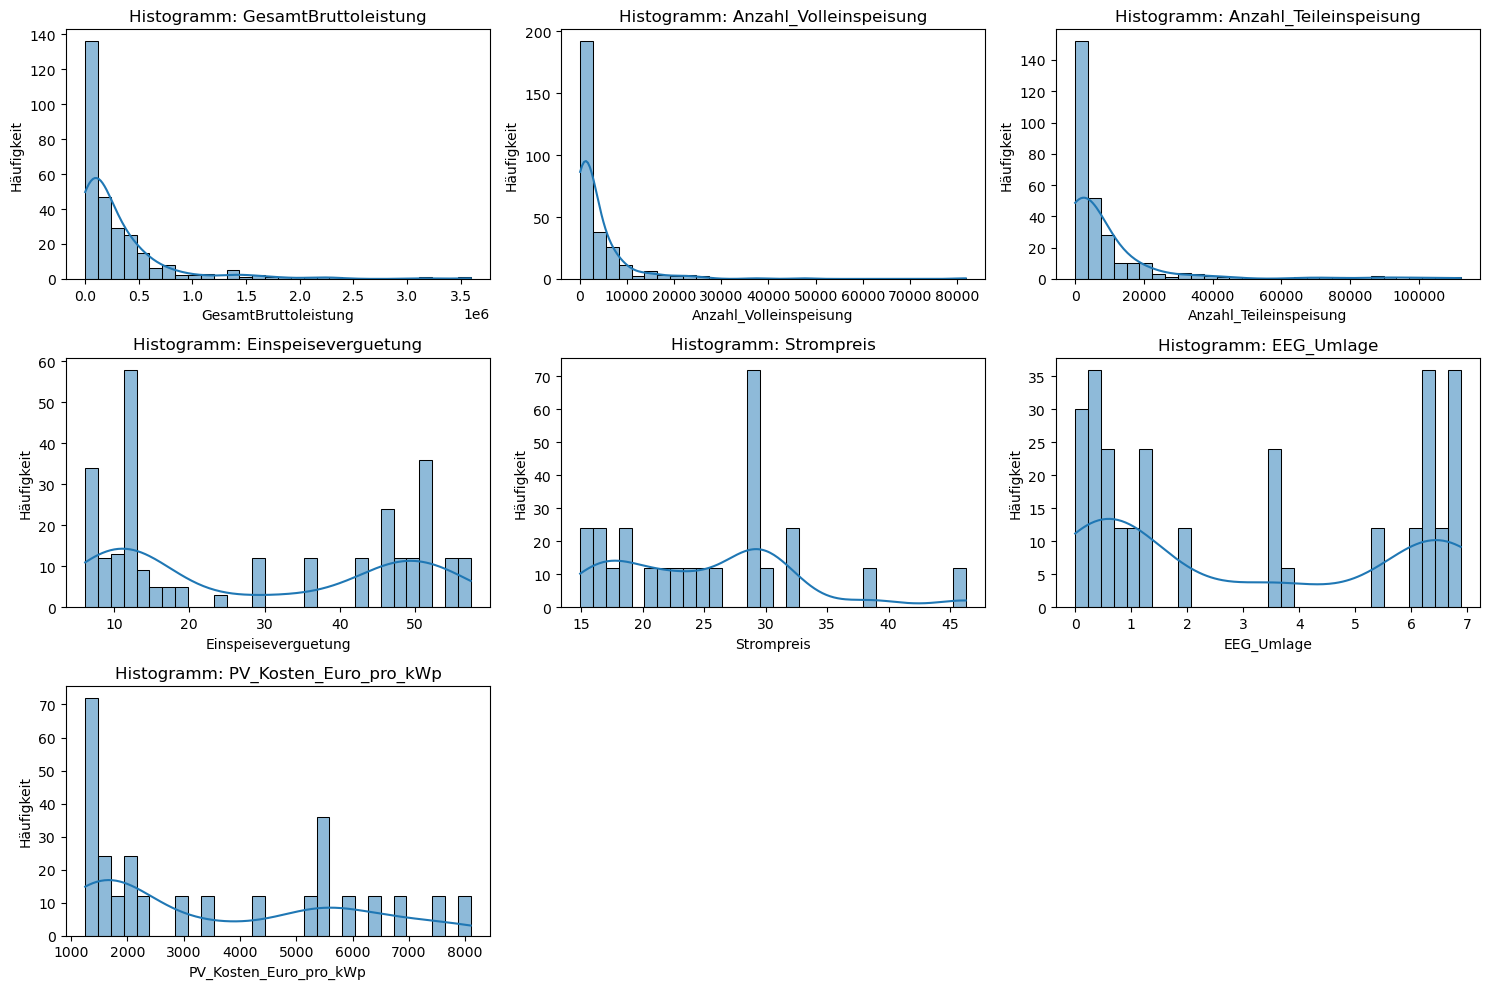

In [46]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(timeseries_df.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(timeseries_df[column], bins=30, kde=True)
    plt.title(f'Histogramm: {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

### Visualiserung der Streuung

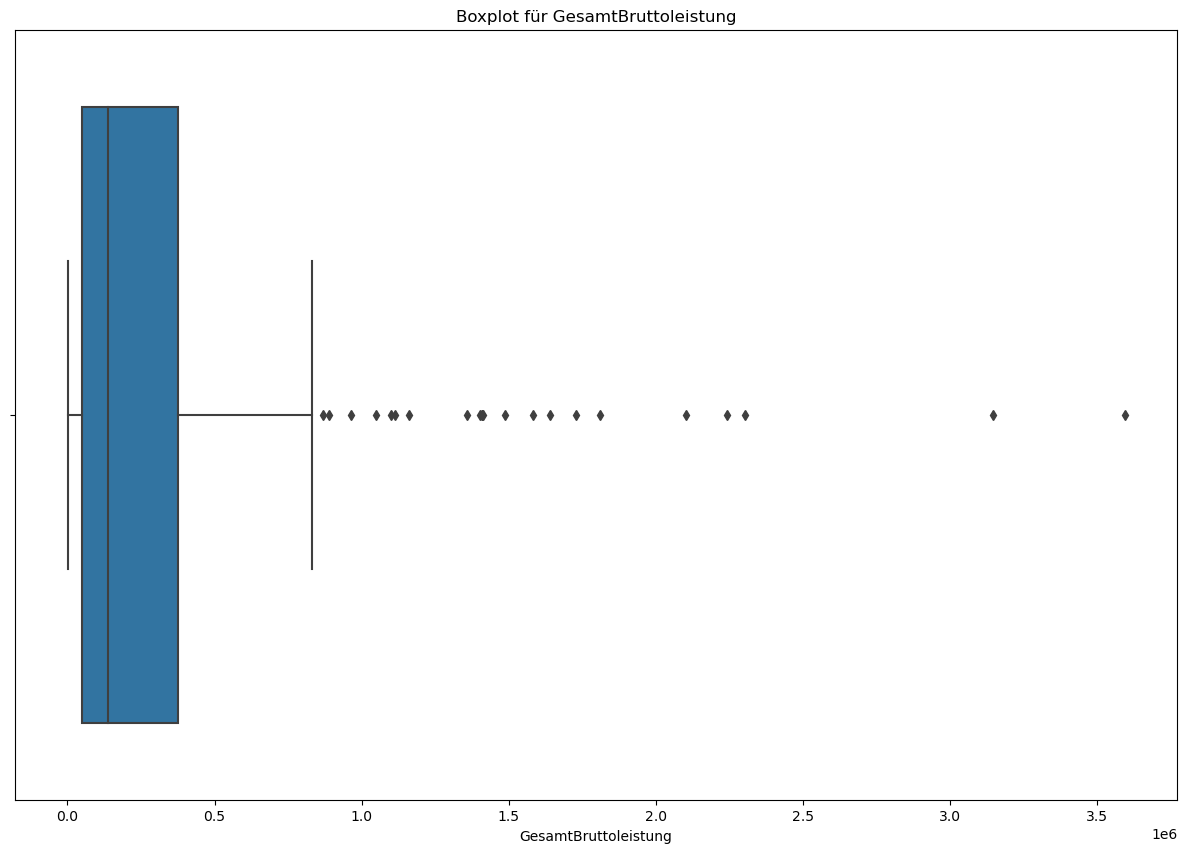

In [47]:
plt.figure(figsize=(15, 10))

target_variable = 'GesamtBruttoleistung'
sns.boxplot(x=timeseries_df[target_variable])

plt.title(f'Boxplot für {target_variable}')
plt.xlabel(target_variable)
plt.show()

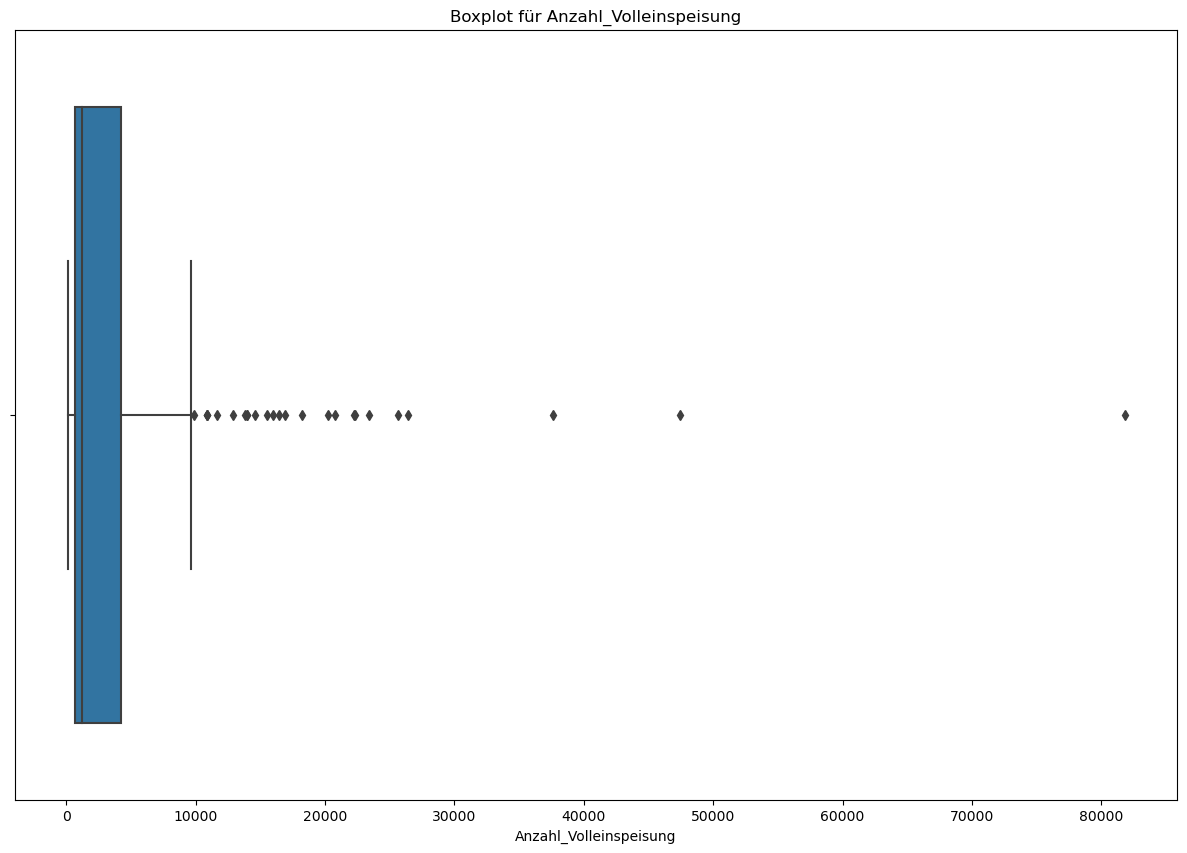

In [48]:
plt.figure(figsize=(15, 10))

target_variable = 'Anzahl_Volleinspeisung'
sns.boxplot(x=timeseries_df[target_variable])

plt.title(f'Boxplot für {target_variable}')
plt.xlabel(target_variable)
plt.show()

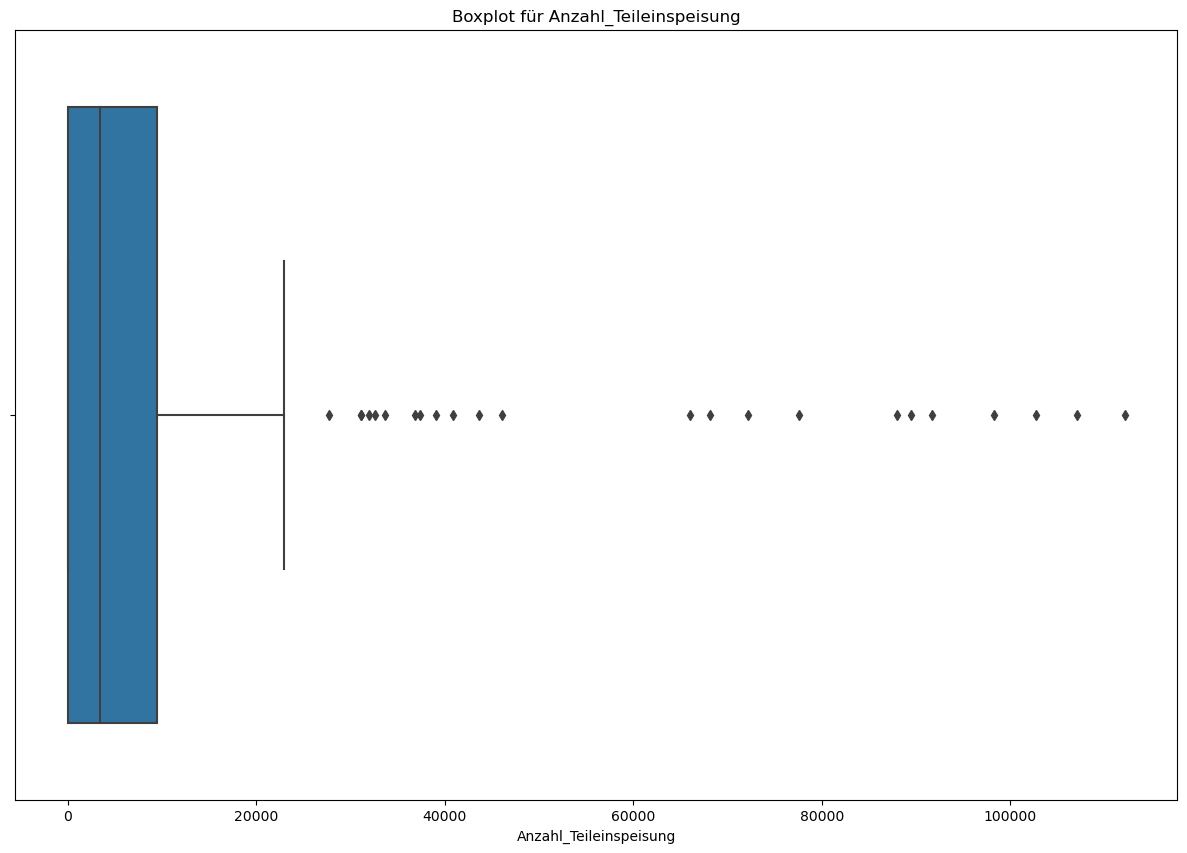

In [49]:
plt.figure(figsize=(15, 10))

target_variable = 'Anzahl_Teileinspeisung'
sns.boxplot(x=timeseries_df[target_variable])

plt.title(f'Boxplot für {target_variable}')
plt.xlabel(target_variable)
plt.show()

## Feature Importance

In [50]:
# Train/Test-Split

X = timeseries_df.drop(['GesamtBruttoleistung'], axis=1)
y = timeseries_df['GesamtBruttoleistung']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Model Training

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

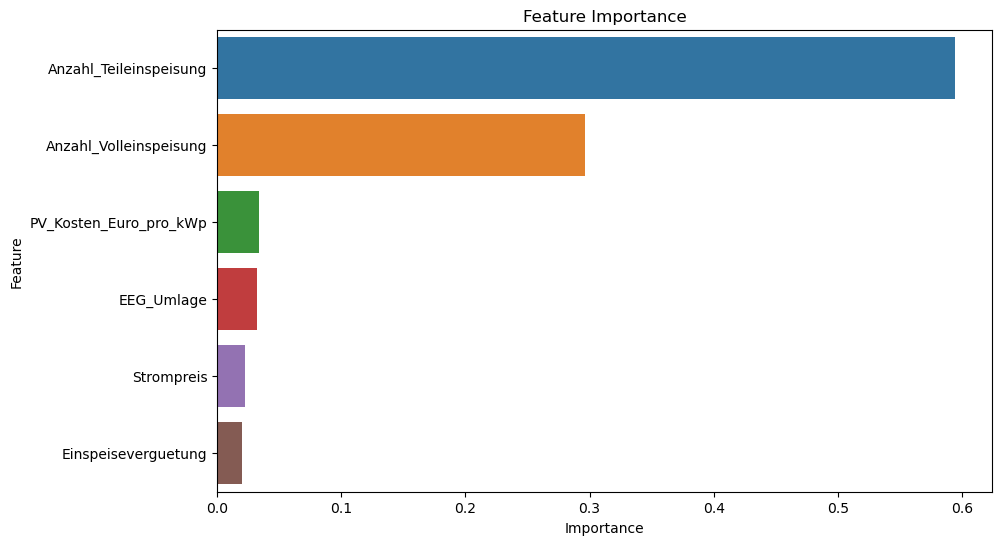

In [52]:
# Feature Importance

feature_importance = rf_model.feature_importances_
feature_names = X_train.columns

# Erstellen Sie ein DataFrame für eine bessere Darstellung
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualisieren Sie die Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

## Multivariate lineare Regression

In [53]:
X = timeseries_df.drop(['GesamtBruttoleistung'], axis=1)
y = timeseries_df['GesamtBruttoleistung']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mv_model = LinearRegression()
mv_model.fit(X_train, y_train)

# Vorhersagen auf dem Testdatensatz
y_pred_mv = mv_model.predict(X_test)

# Evaluieren Sie die Leistung des Modells
mse_mv = mean_squared_error(y_test, y_pred_mv)
r2_mv = r2_score(y_test, y_pred_mv)

print(f'Mean Squared Error: {mse_mv}')
print(f'R2 Score: {r2_mv}')


Mean Squared Error: 61428708356.77914
R2 Score: 0.7847432650058241


## Multivariate OLS Regression
Quelle: https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Multivariate-Approaches/Multiple-linear-regression/MLR-simple-example/index.html   

In [54]:
model_1 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + EEG_Umlage + PV_Kosten_Euro_pro_kWp", data=timeseries_df)
results_1 = model_1.fit()
print(results_1.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.829
Model:                              OLS   Adj. R-squared:                  0.825
Method:                   Least Squares   F-statistic:                     226.7
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          1.46e-104
Time:                          10:38:20   Log-Likelihood:                -3913.1
No. Observations:                   288   AIC:                             7840.
Df Residuals:                       281   BIC:                             7866.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [55]:
model_2 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis", data=timeseries_df)
results_2 = model_2.fit()
print(results_2.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.828
Model:                              OLS   Adj. R-squared:                  0.826
Method:                   Least Squares   F-statistic:                     340.9
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          7.10e-107
Time:                          10:38:20   Log-Likelihood:                -3913.6
No. Observations:                   288   AIC:                             7837.
Df Residuals:                       283   BIC:                             7856.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

**Ergebisse:**   
Model_2 schneidet insgesamt etwas besser ab.  
Alle Variablen (Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis) sind statistisch signifikant.    
Der R-squared-Wert liegt bei 0,828. Das heißt, das Modell ist gut an die Daten angepasst und erklärt die Zielvariable zu 82,8%.  
AIC und BIC sind minimal besser als in Model_1.

### Prüfen der Voraussetzungen für die lineare Regression
Quellen:   
https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html    
https://statistikguru.de/spss/multiple-lineare-regression/voraussetzungen.html     
https://www.statsmodels.org/0.6.1/generated/statsmodels.stats.stattools.durbin_watson.html
https://scholar.archive.org/work/or3wy32qobccfm2qu5o2anamci/access/wayback/http://conference.scipy.org:80/proceedings/scipy2011/pdfs/statsmodels.pdf   
https://statistikguru.de/spss/multiple-lineare-regression/voraussetzungen.html   

In [56]:
# Berechnen der VIF-Werte
independent_vars = timeseries_df[["Anzahl_Volleinspeisung", "Anzahl_Teileinspeisung", "Einspeiseverguetung", "Strompreis"]]

vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(independent_vars.shape[1])]
print(vif_data)

                 Variable       VIF
0  Anzahl_Volleinspeisung  1.388385
1  Anzahl_Teileinspeisung  2.157373
2     Einspeiseverguetung  2.714064
3              Strompreis  3.789006


**Variance Inflation Factor (Prüfung auf Multikollinearität)**   
Berechnung des Variance Inflation Factor (VIF) für jede unabhängige Variable.    
Der VIF misst, wie stark die Varianz eines Regressionskoeffizienten aufgrund von Multikollinearität erhöht ist. Ein hoher VIF-Wert (typischerweise größer als 10) kann auf Multikollinearität hinweisen.

**Ergebnis:**
Alle VIF-Werte liegen unter 5, was für eine geringe bis moderate Multikollinearität des Modells spricht.

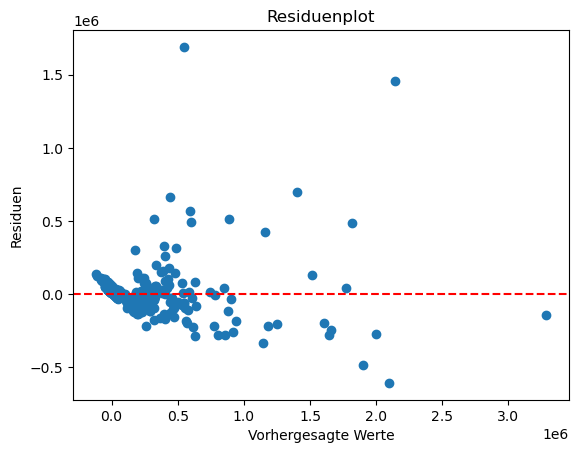

In [57]:
# Residuenplots
predicted_values = results_2.predict()
residuals = results_2.resid

plt.scatter(predicted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen')
plt.title('Residuenplot')
plt.show()


**Residuenplot (Prüfung auf Homoskedastizität)**    
**Ergebnis:**   
Es gibt zwei Ausreiser im hohen positiven Bereich. Alle anderen Werte bewegen sich um bzw. nahe Null, was der gewünschten Verteilung entspricht.

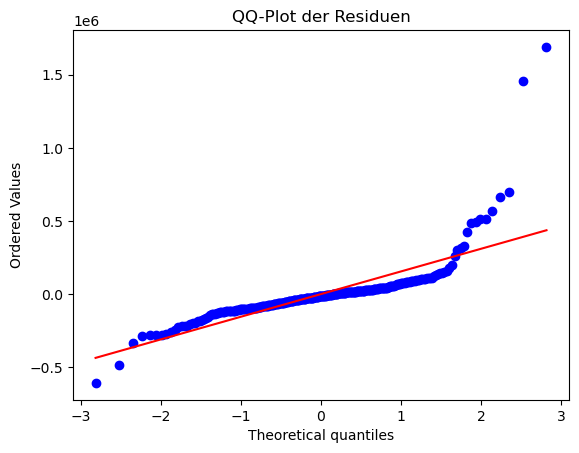

In [58]:
# QQ-Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-Plot der Residuen')
plt.show()

**QQ-Plot (Prüfung auf Normalität)**    
**Ergebnis:**   

Die Punkte in der Mitte des Diagramms verlaufen annähernd entlang einer Linie.   
An den Enden knickt die Linie jedoch ab.    
Das bedeutet, dass die Daten mehr Extremwerte aufweisen, als das aus einer Normalverteilung zu erwarten wäre.

In [59]:
# Shapiro-Wilk-Test auf Normalität
shapiro_test_statistic, shapiro_test_p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test Statistik: {shapiro_test_statistic}, p-Wert: {shapiro_test_p_value}')

Shapiro-Wilk Test Statistik: 0.6446444392204285, p-Wert: 4.501381136862675e-24


**Shapiro-Wilk-Test (Prüfen auf Normalität)**    
**Ergebnis:**    
Der Test-Statistikwert kann Werte zwischen 0 und 1 annehmen, wobei ein Wert näher 1 einer Normalverteilung entspricht.    
Das Ergebnis lautet 0,645.    
Der sehr niedrige p-Wert nahe 0 spricht dafür, dass die Residuen nicht normal verteilt sind. 
Bei einer ausreichend großen Sample-Größe, wie es hier gegeben ist, kann die Stichprobenverteilung des Mittelwertes laut zentralem Grenzwertsatz dennoch als normal betracht werden.   

In [60]:
# Durbin-Watson-Test
dw_statistic = durbin_watson(residuals)
print(f'Durbin-Watson-Statistik: {dw_statistic}')

Durbin-Watson-Statistik: 1.7074169279406068


**Durbin-Watson-Test (Prüfen auf Autokorrelation)**   
**Ergebnis:**  
Da der Wert zwischen 1,5 und 2,5 liegt, kann die Autokorrelation in diesem Regressionsmodell als unproblematisch betrachtet werden.

### Feature Engineering   
Quellen:    
https://medium.com/@serkanemreelci/feature-engineering-and-linear-regression-470dd9879e37    
https://www.linkedin.com/pulse/enhancing-linear-regression-using-feature-engineering-pholo-moanda/
https://towardsdatascience.com/feature-engineering-combination-polynomial-features-3caa4c77a755
https://www.kaggle.com/code/aks709/linear-regression-with-feature-engineering


#### Log-Transformation der Variablen:

In [61]:
timeseries_log_df = timeseries_df.copy()
timeseries_log_df['log_Anzahl_Volleinspeisung'] = np.log(timeseries_df['Anzahl_Volleinspeisung'])
timeseries_log_df['log_Anzahl_Teileinspeisung'] = np.log(timeseries_df['Anzahl_Teileinspeisung'])
timeseries_log_df['log_Einspeiseverguetung'] = np.log(timeseries_df['Einspeiseverguetung'])
timeseries_log_df['log_Strompreis'] = np.log(timeseries_df['Strompreis'])
timeseries_log_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp,log_Anzahl_Volleinspeisung,log_Anzahl_Teileinspeisung,log_Einspeiseverguetung,log_Strompreis
Jahr_Monat,,,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100,8.845633,7.870930,3.924347,2.702703
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100,4.595120,3.218876,3.924347,2.702703
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100,5.093750,3.044522,3.924347,2.702703
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100,6.769642,5.030438,3.924347,2.702703
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100,6.563856,5.087596,3.924347,2.702703
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250,8.244597,11.495444,2.034706,3.834494
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250,8.144098,11.401413,2.034706,3.834494
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250,8.009031,11.258717,2.034706,3.834494


In [62]:
model_3 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + log_Anzahl_Volleinspeisung + log_Anzahl_Teileinspeisung", data=timeseries_log_df)
results_3 = model_3.fit()
print(results_3.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.828
Model:                              OLS   Adj. R-squared:                  0.824
Method:                   Least Squares   F-statistic:                     225.7
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          2.39e-104
Time:                          10:38:20   Log-Likelihood:                -3913.6
No. Observations:                   288   AIC:                             7841.
Df Residuals:                       281   BIC:                             7867.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [63]:
model_4 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + log_Einspeiseverguetung", data=timeseries_log_df)
results_4 = model_4.fit()
print(results_4.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.830
Model:                              OLS   Adj. R-squared:                  0.827
Method:                   Least Squares   F-statistic:                     275.0
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          3.59e-106
Time:                          10:38:20   Log-Likelihood:                -3912.2
No. Observations:                   288   AIC:                             7836.
Df Residuals:                       282   BIC:                             7858.
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interc

**Ergebnis:** Keine signifikante Verbesserung des Models durch logarithmieren der Variablen.

#### Polynomielle Transformation der Variablen:

In [64]:
timeseries_squared_df = timeseries_df.copy()
timeseries_squared_df['squared_Anzahl_Volleinspeisung'] = timeseries_df['Anzahl_Volleinspeisung']**2
timeseries_squared_df['squared_Anzahl_Teileinspeisung'] = timeseries_df['Anzahl_Teileinspeisung']**2
timeseries_squared_df['squared_Einspeiseverguetung'] = timeseries_df['Einspeiseverguetung']**2
timeseries_squared_df['squared_Strompreis'] = timeseries_df['Strompreis']**2
timeseries_squared_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp,squared_Anzahl_Volleinspeisung,squared_Anzahl_Teileinspeisung,squared_Einspeiseverguetung,squared_Strompreis
Jahr_Monat,,,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100,48219136,6864400,2562.3844,222.6064
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100,9801,625,2562.3844,222.6064
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100,26569,441,2562.3844,222.6064
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100,758641,23409,2562.3844,222.6064
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100,502681,26244,2562.3844,222.6064
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250,14493249,9656403289,58.5225,2140.9129
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250,11854249,8000944704,58.5225,2140.9129
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250,9048064,6014467809,58.5225,2140.9129


In [65]:
model_5 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + squared_Anzahl_Teileinspeisung + squared_Anzahl_Volleinspeisung", data=timeseries_squared_df)
results_5 = model_5.fit()
print(results_5.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.852
Model:                              OLS   Adj. R-squared:                  0.848
Method:                   Least Squares   F-statistic:                     268.6
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          3.05e-113
Time:                          10:38:21   Log-Likelihood:                -3892.6
No. Observations:                   288   AIC:                             7799.
Df Residuals:                       281   BIC:                             7825.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

**Ergebnis:** Leichte Verbesserung des Modells durch quadrieren der Anzahl Voll- und Teileinspeisungen.

#### BoxCox-Transformation der Variablen:

In [66]:
timeseries_bc_df = timeseries_df.copy()
timeseries_bc_df['bc_Anzahl_Volleinspeisung'], _ = boxcox(timeseries_df['Anzahl_Volleinspeisung'] + 1)
timeseries_bc_df['bc_Anzahl_Teileinspeisung'], _ = boxcox(timeseries_df['Anzahl_Teileinspeisung'] + 1)
timeseries_bc_df['bc_Einspeiseverguetung'], _ = boxcox(timeseries_df['Einspeiseverguetung'] + 1)
timeseries_bc_df['bc_Strompreis'], _ = boxcox(timeseries_df['Strompreis'] + 1)
timeseries_bc_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp,bc_Anzahl_Volleinspeisung,bc_Anzahl_Teileinspeisung,bc_Einspeiseverguetung,bc_Strompreis
Jahr_Monat,,,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100,3.844447,10.526549,5.492086,2.366439
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100,2.870946,3.663252,5.492086,2.366439
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100,3.037562,3.454231,5.492086,2.366439
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100,3.481313,6.048797,5.492086,2.366439
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100,3.435272,6.130011,5.492086,2.366439
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250,3.756045,17.725640,2.575553,3.107421
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250,3.740066,17.514646,2.575553,3.107421
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250,3.718017,17.197117,2.575553,3.107421


In [67]:
model_8 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + bc_Anzahl_Volleinspeisung + bc_Anzahl_Teileinspeisung", data=timeseries_bc_df)
results_8 = model_8.fit()
print(results_8.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.829
Model:                              OLS   Adj. R-squared:                  0.825
Method:                   Least Squares   F-statistic:                     226.5
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          1.62e-104
Time:                          10:38:21   Log-Likelihood:                -3913.2
No. Observations:                   288   AIC:                             7840.
Df Residuals:                       281   BIC:                             7866.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
In

#### Kombination von zwei Variablen:

In [68]:
timeseries_fe_df = timeseries_df.copy()
timeseries_fe_df['Product_Einspeisung_Strompreis'] = timeseries_df['Einspeiseverguetung'] * timeseries_df['Strompreis']
timeseries_fe_df['Product_PV_Anlagen'] = timeseries_df['Anzahl_Volleinspeisung'] * timeseries_df['Anzahl_Teileinspeisung']
timeseries_fe_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp,Product_Einspeisung_Strompreis,Product_PV_Anlagen
Jahr_Monat,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100,755.2504,18193280
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100,755.2504,2475
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100,755.2504,3423
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100,755.2504,133263
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100,755.2504,114858
...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250,353.9655,374102469
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250,353.9655,307969464
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250,353.9655,233279424


In [69]:
model_6 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + Product_PV_Anlagen + Product_Einspeisung_Strompreis", data=timeseries_fe_df)
results_6 = model_6.fit()
print(results_6.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.868
Model:                              OLS   Adj. R-squared:                  0.866
Method:                   Least Squares   F-statistic:                     309.1
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          1.32e-120
Time:                          10:38:21   Log-Likelihood:                -3875.1
No. Observations:                   288   AIC:                             7764.
Df Residuals:                       281   BIC:                             7790.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [70]:
# VIF für jedes Feature
X_no_intercept = timeseries_fe_df.drop(['GesamtBruttoleistung'], axis=1)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_no_intercept.columns
vif_data["VIF"] = [variance_inflation_factor(X_no_intercept.values, i) for i in range(X_no_intercept.shape[1])]

print(vif_data)

                         Variable         VIF
0          Anzahl_Volleinspeisung    3.507804
1          Anzahl_Teileinspeisung   13.560706
2             Einspeiseverguetung  376.960731
3                      Strompreis   78.177176
4                      EEG_Umlage   15.919044
5          PV_Kosten_Euro_pro_kWp   75.868231
6  Product_Einspeisung_Strompreis  246.372929
7              Product_PV_Anlagen    3.748194


In [71]:
timeseries_fe2_df = timeseries_df.copy()

timeseries_fe2_df['Diff_Einspeisung_Strompreis'] = timeseries_df['Einspeiseverguetung'] * timeseries_df['Strompreis']
timeseries_fe2_df['Anzahl_PV_Anlagen'] = timeseries_df['Anzahl_Volleinspeisung'] * timeseries_df['Anzahl_Teileinspeisung']

timeseries_fe2_df['squared_Anzahl_Volleinspeisung'] = timeseries_df['Anzahl_Volleinspeisung']**2
timeseries_fe2_df['squared_Anzahl_Teileinspeisung'] = timeseries_df['Anzahl_Teileinspeisung']**2
timeseries_fe2_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,EEG_Umlage,PV_Kosten_Euro_pro_kWp,Diff_Einspeisung_Strompreis,Anzahl_PV_Anlagen,squared_Anzahl_Volleinspeisung,squared_Anzahl_Teileinspeisung
Jahr_Monat,,,,,,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,0.2,8100,755.2504,18193280,48219136,6864400
2000-02-01,757.749,99,25,50.62,14.92,0.2,8100,755.2504,2475,9801,625
2000-03-01,698.163,163,21,50.62,14.92,0.2,8100,755.2504,3423,26569,441
2000-04-01,3479.965,871,153,50.62,14.92,0.2,8100,755.2504,133263,758641,23409
2000-05-01,3285.015,709,162,50.62,14.92,0.2,8100,755.2504,114858,502681,26244
...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,0.0,1250,353.9655,374102469,14493249,9656403289
2023-09-01,1358857.379,3443,89448,7.65,46.27,0.0,1250,353.9655,307969464,11854249,8000944704
2023-10-01,2101186.830,3008,77553,7.65,46.27,0.0,1250,353.9655,233279424,9048064,6014467809


In [72]:
model_7 = smf.ols(formula="GesamtBruttoleistung ~ Anzahl_Volleinspeisung + Anzahl_Teileinspeisung + Einspeiseverguetung + Strompreis + Anzahl_PV_Anlagen + Diff_Einspeisung_Strompreis + squared_Anzahl_Volleinspeisung + squared_Anzahl_Teileinspeisung", data=timeseries_fe2_df)
results_7 = model_7.fit()
print(results_7.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.881
Model:                              OLS   Adj. R-squared:                  0.878
Method:                   Least Squares   F-statistic:                     258.8
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):          2.61e-124
Time:                          10:38:21   Log-Likelihood:                -3860.4
No. Observations:                   288   AIC:                             7739.
Df Residuals:                       279   BIC:                             7772.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

**Ergebnisse:**   
**Modell 7** liefert den besten R-squared-Wert. Aber mehrere Variablen haben einenp-Wert über 0,05 und sind somit nicht mehr signifikant.   

**Modell 6 liefert die beste Performance.**      
R-squared und adjusted R-squared liegen sehr nah beieinander. Das adjusted R-squared konnte auf 0,868 verbessert werden. Das bedeuted, dass die Zielvariable zu 86,8% durch die unabhängigen Variablen erklärt wird.   
Alle p-Werte liegen unter 0,05 und sind somit signifikant.
Allerdings zeigen die VIF-Werte eine deutliche Multikollinearität 

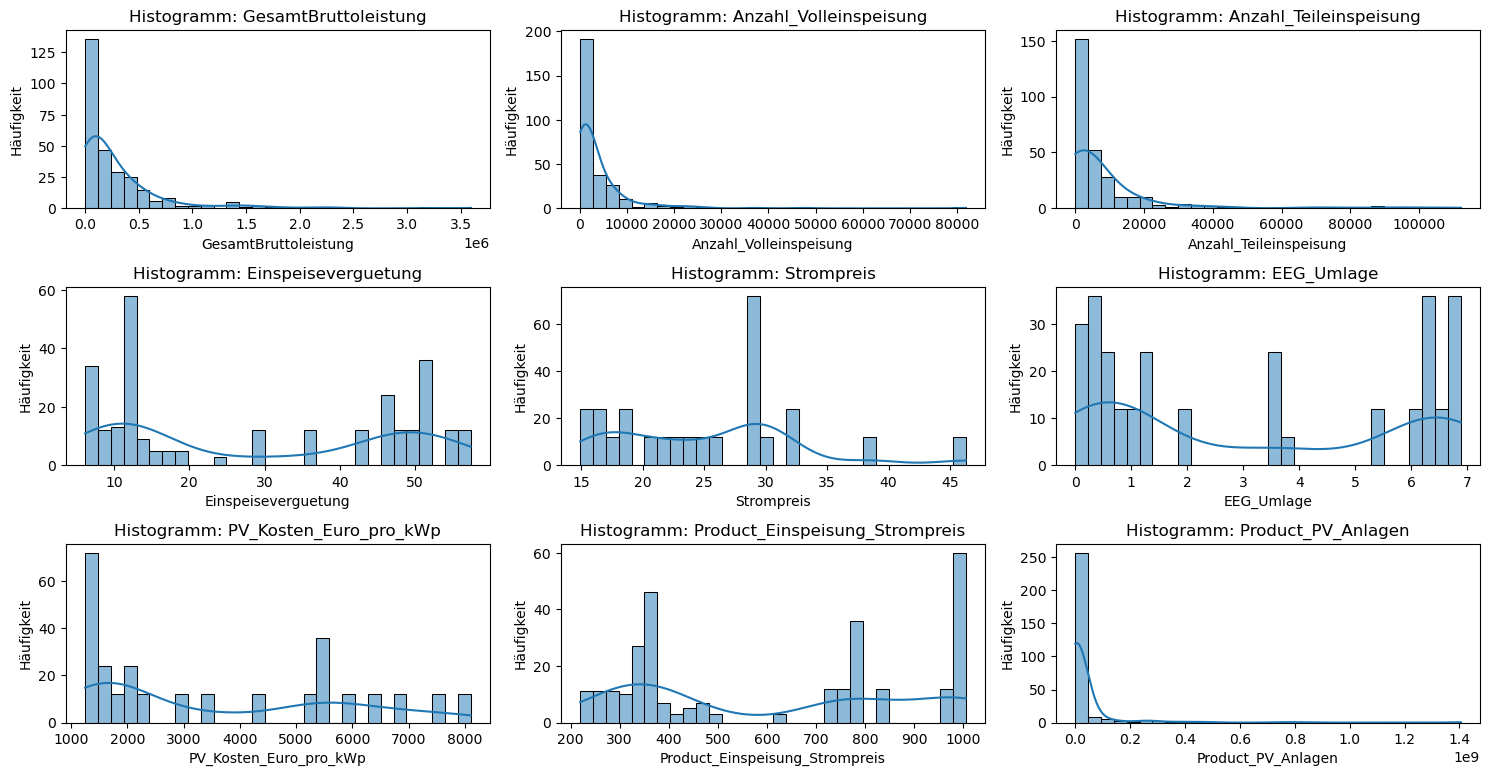

In [73]:
# Histogramme Verteilung der Variablen
plt.figure(figsize=(15, 10))
for i, column in enumerate(timeseries_fe_df.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(timeseries_fe_df[column], bins=30, kde=True)
    plt.title(f'Histogramm: {column}')
    plt.xlabel(column)
    plt.ylabel('Häufigkeit')

plt.tight_layout()
plt.show()

**Zwischen-Ergebnisse und weiteres Vorgehen:**   
Die Variablen GesamtBruttoleistung, Anzahl_Volleinspeisung und Anzahl_Teileinspeisung sind stark verzerrt.   

Alle anderen Variablen zeigen keine Normalverteilung.  

Das kann zu verzerrten Annahmen zur Signifikanz der einzelnen Prädiktoren sowie zu Stärke und Richtung der Beziehungen zwischen den Variablen führen. Zudem können Inferenzen und Konfidenzintervalle inkorrekt ausfallen.
Daher werden die Ergebnisse der OLS-Regression mit Random Forests, Gradient Boosting und weiteren Modellen verglichen, die nichtlineare Beziehungen besser abbilden.   

Als Datengrundlage wird der ursprüngliche Datensatz timeseries_df benutzt, um die Erklärbarkeit des Models zu erhalten und Multikollinearität auszuschließen.

## Vergleich Lineare Regression vs. andere Modelle

### Train / Test-Split

In [74]:
# Train/Test-Split
X = timeseries_df.drop(['GesamtBruttoleistung'], axis=1)
y = timeseries_df['GesamtBruttoleistung']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
#X_train

In [76]:
#X_test

In [77]:
features = timeseries_df[['Anzahl_Volleinspeisung', 'Anzahl_Teileinspeisung', 'Einspeiseverguetung', 'Strompreis', 'PV_Kosten_Euro_pro_kWp']]
target = timeseries_df['GesamtBruttoleistung']

### Lineare Regression

In [78]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

y_pred = linear_reg_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R²: {r2}')
print(f'Mean Squared Error: {mse}')

R²: 0.7847432650058241
Mean Squared Error: 61428708356.77914


### Random Forest

In [79]:
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)

y_pred_rf = random_forest_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print(f'R² für Random Forest: {r2_rf}')
print(f'Mean Squared Error für Random Forest: {mse_rf}')

R² für Random Forest: 0.6179187876829131
Mean Squared Error für Random Forest: 109036102218.43224


### Gradient Boosting

In [80]:
gradient_boosting_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gradient_boosting_model.fit(X_train, y_train)

# Vorhersagen auf den Testdaten
y_pred_gb = gradient_boosting_model.predict(X_test)

# Bewertung des Gradient-Boosting-Modells
r2_gb = r2_score(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)

print(f'R² für Gradient Boosting: {r2_gb}')
print(f'Mean Squared Error für Gradient Boosting: {mse_gb}')

R² für Gradient Boosting: 0.7346956609451659
Mean Squared Error für Gradient Boosting: 75711000959.05664


### Arima

In [81]:
y = timeseries_df['GesamtBruttoleistung']

model = ARIMA(y, order=(120, 1, 0))

model_fit = model.fit()
y_pred_arima = model_fit.predict()

# Evaluation
rmse_arima = sqrt(mean_squared_error(y, y_pred_arima))
r2_arima = r2_score(y, y_pred_arima)
print(f'Root Mean Squared Error (ARIMA): {rmse_arima}')
print(f'R² (ARIMA): {r2_arima}')

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Squared Error (ARIMA): 241586.36183318438
R² (ARIMA): 0.7305043488730109


### Sarimax 

In [82]:
order = (6, 1, 0)  # (p, d, q) für nicht-saisonale Komponenten
seasonal_order = (12, 1, 2, 12)  # (P, D, Q, S) für saisonale Komponenten

sarima_model = SARIMAX(y, order=order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

y_pred_sarima = sarima_model_fit.predict()

# Evaluation
rmse_sarima = sqrt(mean_squared_error(y, y_pred_sarima))
r2_sarima = r2_score(y, y_pred_sarima)
print(f'Root Mean Squared Error (SARIMA): {rmse_sarima}')
print(f'R² (SARIMA): {r2_sarima}')

C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Conny\anaconda3\envs\geo_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Squared Error (SARIMA): 298596.4353540038
R² (SARIMA): 0.588304450962982


### LASSO und Ridge Regression

In [83]:
# Daten skalieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:
# LASSO
lasso_model = Lasso(alpha=1.0)  # Wähle den Alpha-Wert entsprechend
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [85]:
# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Wähle den Alpha-Wert entsprechend
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [86]:
# Evaluation
y_pred_lasso = lasso_model.predict(X_test_scaled)
r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

y_pred_ridge = ridge_model.predict(X_test_scaled)
r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("LASSO - R²:", r2_lasso, "MSE:", mse_lasso)
print("Ridge - R²:", r2_ridge, "MSE:", mse_ridge)

LASSO - R²: 0.7847387425646375 MSE: 61429998944.600784
Ridge - R²: 0.78055534197119 MSE: 62623833344.26041


**Ergebnisse:**
Die Lineare Regression liefert die besten Ergebnisse.   
Lasso- und Ridge-Regression liefern ähnlich gute Resultate, sind aber nicht so gut interprtierbar wie die Lineare Regression.  

### Bootstrapping (Prüfung auf Robustheit)    
Quellen:  
https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9    
https://www.linkedin.com/pulse/linear-regression-bootstrapping-ali-mirzaei/    
https://www.researchgate.net/post/How_to_interpret_bootstrapping_multiple_linear_regression    
ChatGPT (siehe ChatGPT Protokoll Seite 19-24)   

In [87]:
def bootstrap_regression(data_df, response_col, n_boots=100):
    boot_results = {}

    for predictor_col in data_df.columns:
        if predictor_col != response_col:
            boot_slopes = []
            boot_interc = []

            for _ in range(n_boots):
                # sample the rows, same size, with replacement
                sample_df = data_df.sample(n=len(data_df), replace=True)

                # fit a linear regression
                ols_model_temp = sm.OLS(sample_df[response_col], sm.add_constant(sample_df[predictor_col]))
                results_temp = ols_model_temp.fit()

                # append coefficients
                boot_interc.append(results_temp.params[0])
                boot_slopes.append(results_temp.params[1])

            boot_results[predictor_col] = {'intercepts': boot_interc, 'slopes': boot_slopes}

    return boot_results

boot_results = bootstrap_regression(timeseries_df, 'GesamtBruttoleistung', n_boots=100)
#boot_results

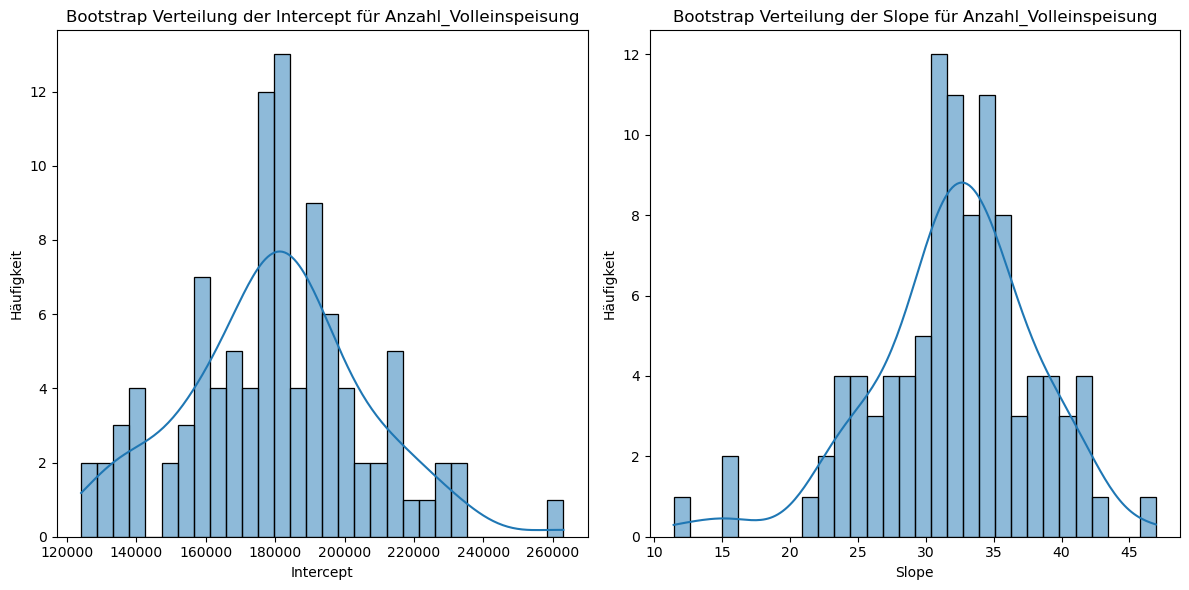

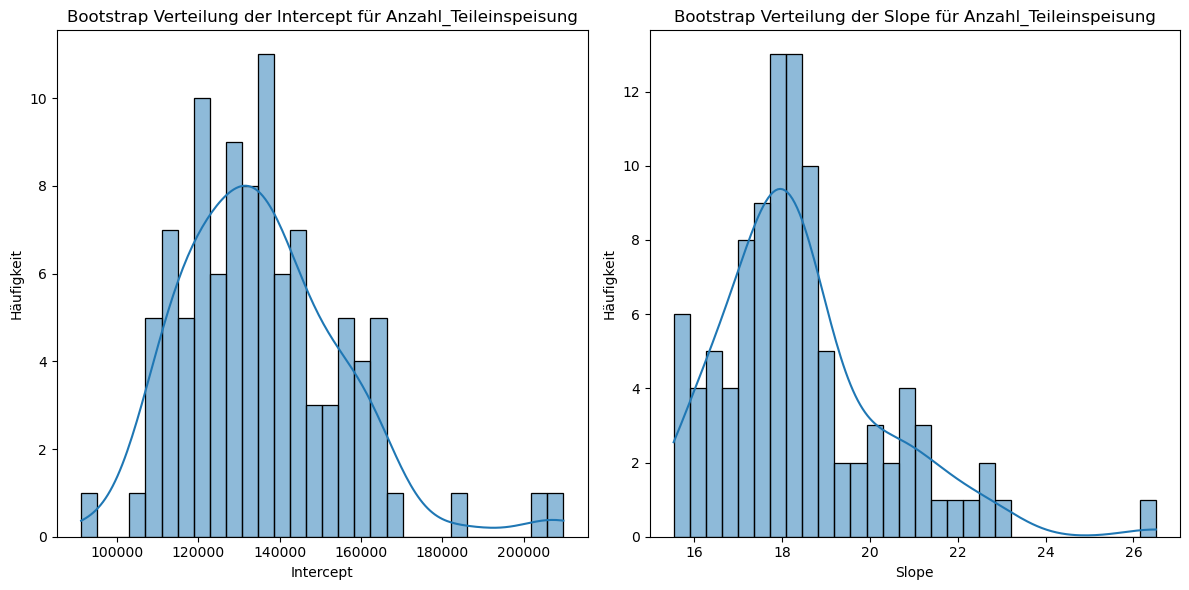

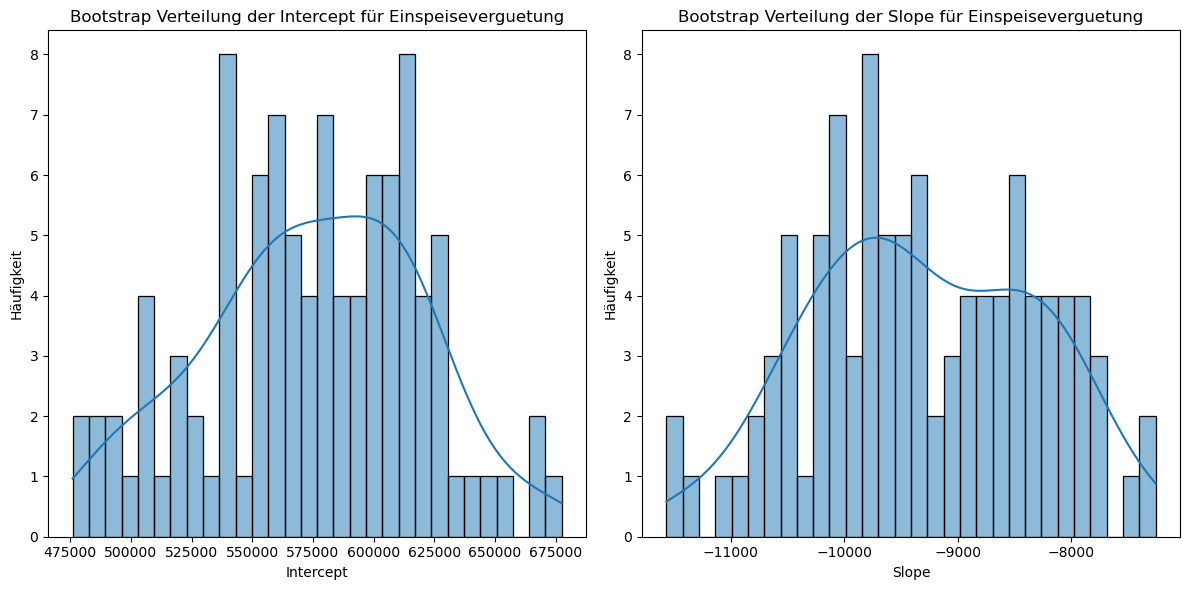

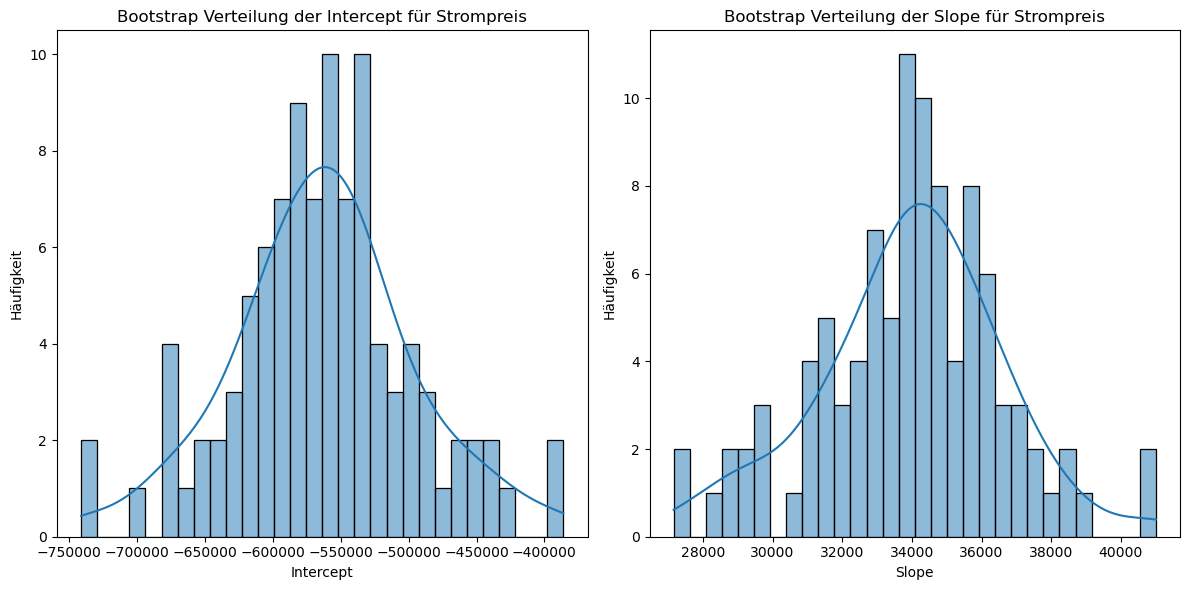

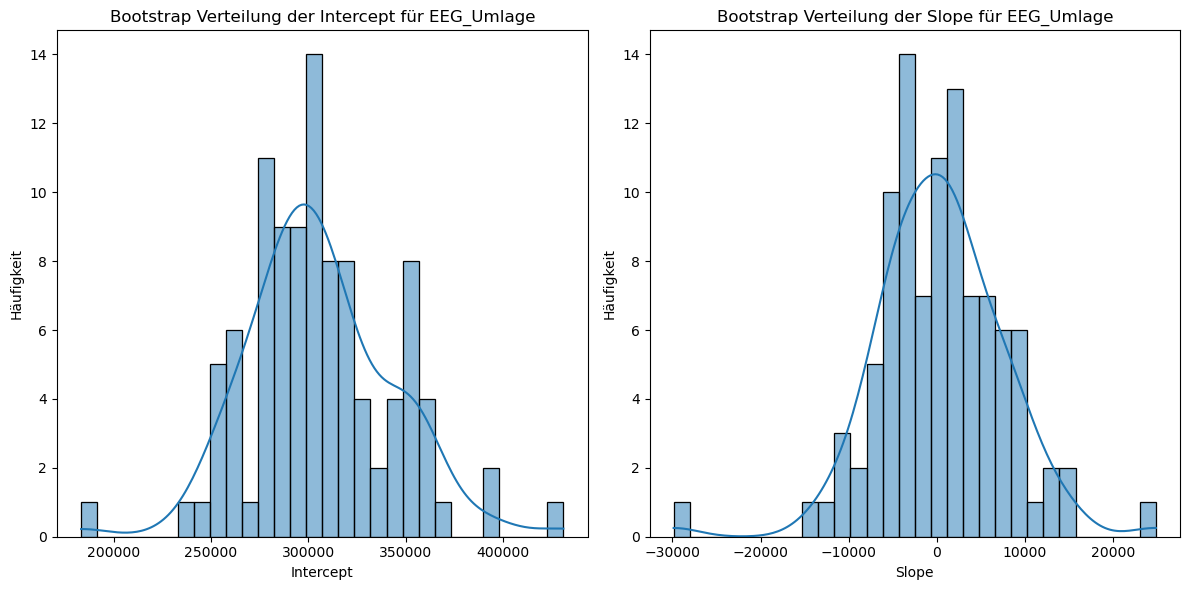

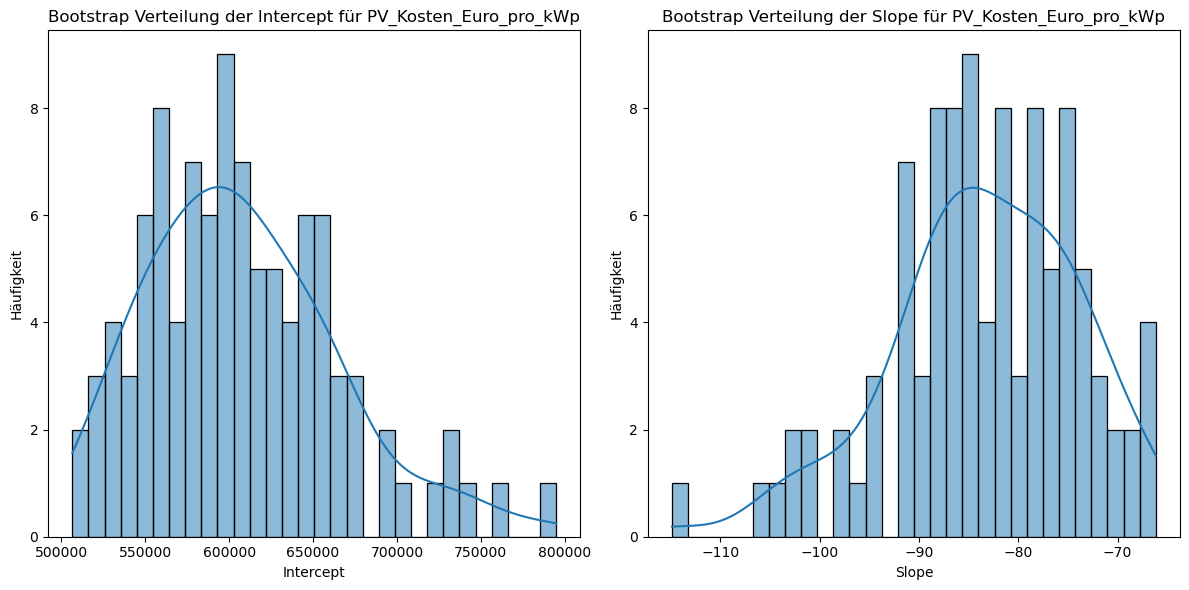

In [88]:
def bootstrap_plot(boot_results):
    for predictor_col, values in boot_results.items():
        plt.figure(figsize=(12, 6))

        # Verteilung der Intercepts
        plt.subplot(1, 2, 1)
        sns.histplot(values['intercepts'], bins=30, kde=True)
        plt.title(f'Bootstrap Verteilung der Intercept für {predictor_col}')
        plt.xlabel('Intercept')
        plt.ylabel('Häufigkeit')

        # Verteilung der Slopes
        plt.subplot(1, 2, 2)
        sns.histplot(values['slopes'], bins=30, kde=True)
        plt.title(f'Bootstrap Verteilung der Slope für {predictor_col}')
        plt.xlabel('Slope')
        plt.ylabel('Häufigkeit')

        plt.tight_layout()
        plt.show()
bootstrap_plot(boot_results)

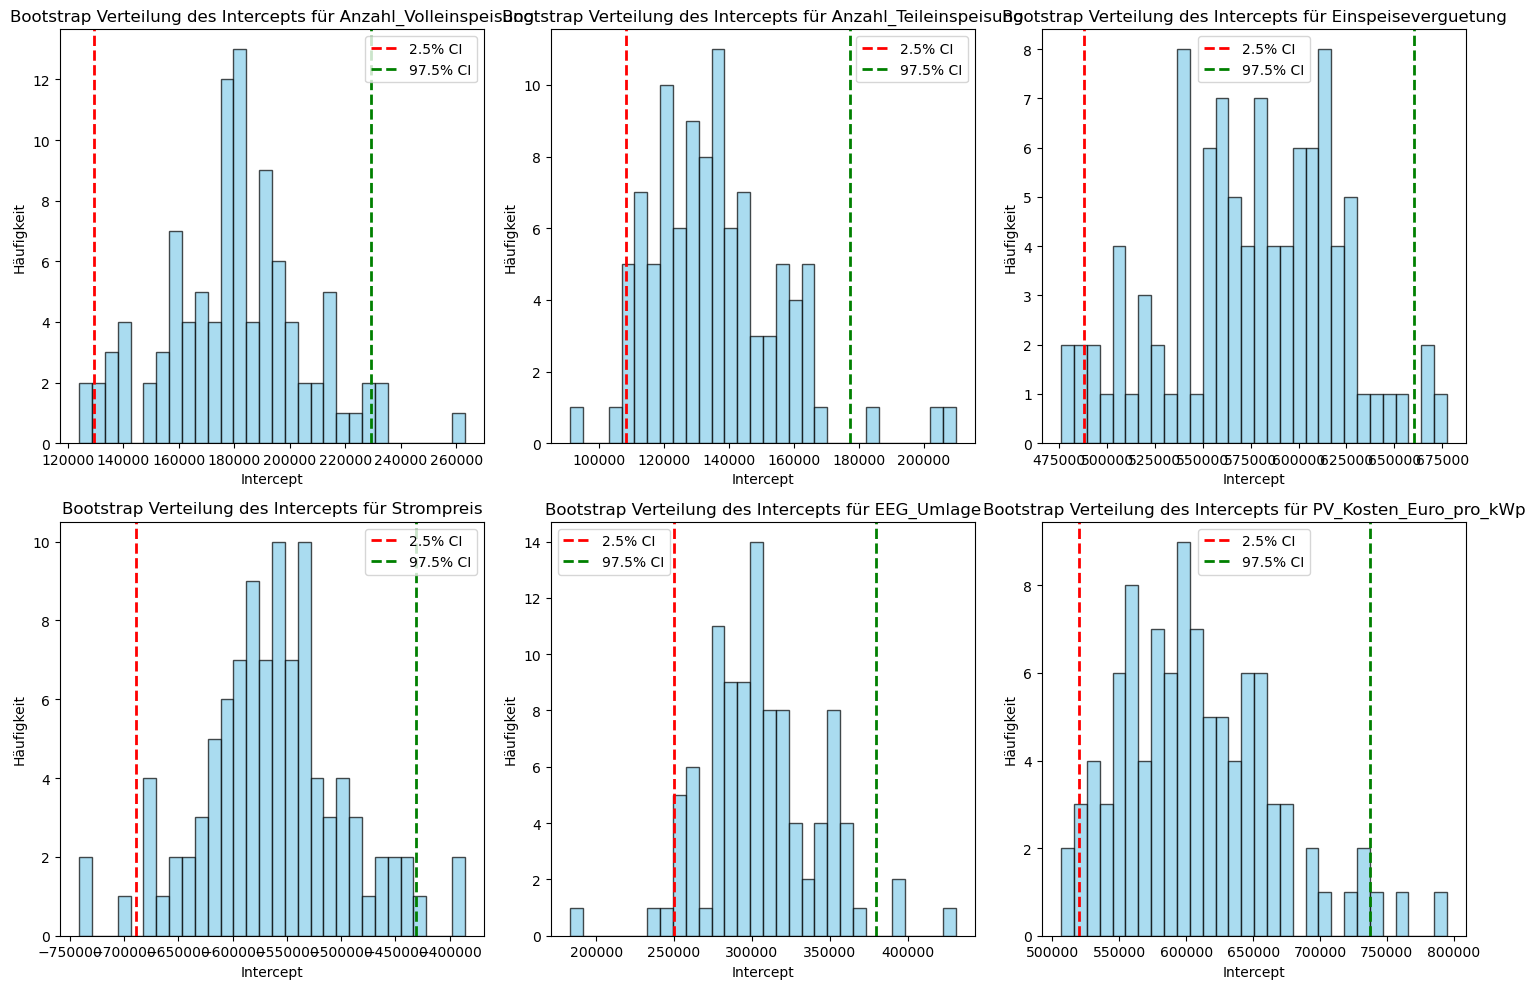

In [89]:
# 95% Konfidenzintervalle
ci_interc = {predictor: np.percentile(results['intercepts'], [2.5, 97.5]) for predictor, results in boot_results.items()}
ci_slopes = {predictor: np.percentile(results['slopes'], [2.5, 97.5]) for predictor, results in boot_results.items()}

# Bootstrap-Verteilungen und Konfidenzintervalle
num_cols = 3
num_rows = int(np.ceil(len(boot_results) / num_cols))

plt.figure(figsize=(15, 5 * num_rows))

for i, (predictor, results) in enumerate(boot_results.items(), 1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(results['intercepts'], bins=30, edgecolor='black', color='skyblue', alpha=0.7)
    plt.axvline(ci_interc[predictor][0], color='red', linestyle='dashed', linewidth=2, label='2.5% CI')
    plt.axvline(ci_interc[predictor][1], color='green', linestyle='dashed', linewidth=2, label='97.5% CI')
    plt.title(f'Bootstrap Verteilung des Intercepts für {predictor}')
    plt.xlabel('Intercept')
    plt.ylabel('Häufigkeit')
    plt.legend()

plt.tight_layout()
plt.show()

In [90]:
# Interpretation der Ergebnisse
for predictor_col, values in boot_results.items():
    # Punktschätzungen der Koeffizienten
    point_estimate = np.mean(values['slopes'])
    print(f"\nPredictor: {predictor_col}")
    print(f"Punktschätzung der Koeffizienten: {point_estimate}")

    # Standardfehler der Koeffizienten
    standard_error = np.std(values['slopes'])
    print(f"Standardfehler der Koeffizienten: {standard_error}")

    # p-Wert der Koeffizienten
    p_value = 2 * min(np.mean(np.array(values['slopes']) <= 0), np.mean(np.array(values['slopes']) >= 0))
    print(f"p-Wert der Koeffizienten: {p_value}")


Predictor: Anzahl_Volleinspeisung
Punktschätzung der Koeffizienten: 32.09688861728157
Standardfehler der Koeffizienten: 5.907881431392974
p-Wert der Koeffizienten: 0.0

Predictor: Anzahl_Teileinspeisung
Punktschätzung der Koeffizienten: 18.414660374615003
Standardfehler der Koeffizienten: 1.8778062767944401
p-Wert der Koeffizienten: 0.0

Predictor: Einspeiseverguetung
Punktschätzung der Koeffizienten: -9304.44474314315
Standardfehler der Koeffizienten: 989.9773492816241
p-Wert der Koeffizienten: 0.0

Predictor: Strompreis
Punktschätzung der Koeffizienten: 33946.50970271803
Standardfehler der Koeffizienten: 2613.4439313073226
p-Wert der Koeffizienten: 0.0

Predictor: EEG_Umlage
Punktschätzung der Koeffizienten: 359.92869603380956
Standardfehler der Koeffizienten: 7167.014664687364
p-Wert der Koeffizienten: 0.96

Predictor: PV_Kosten_Euro_pro_kWp
Punktschätzung der Koeffizienten: -83.4526785151134
Standardfehler der Koeffizienten: 9.396506019715362
p-Wert der Koeffizienten: 0.0


**Ergebnisse:**   
Die Konfidenzintervalle schließen die Null nicht ein.    
Das deutet darauf hin, dass die Prädiktorvariablen signifikant mit der Zielvariablen verbunden ist. 

Die **Punktschätzungen der Koeffizienten** repräsentieren die geschätzten Veränderungen in der abhängigen Variable 'GesamtBruttoleistung' für eine Einheit Veränderung in der entsprechenden unabhängigen Variable, wenn alle anderen Variablen konstant gehalten werden.

Die **Standardfehler der Koeffizienten** geben an, wie genau die Punktschätzungen sind. Kleinere Standardfehler deuten auf präzisere Schätzungen hin.

Die **p-Werte der Koeffizienten** liefern Informationen darüber, ob die geschätzten Koeffizienten signifikant von Null abweichen. Ein kleiner p-Wert (typischerweise kleiner als 0,05) deutet darauf hin, dass der Koeffizient signifikant ist. Alle Predictoren außer 'EEG_Umlage sind hochsignifikant. Insofern sollte dieser Predictor aus dem Model entfernt werden.

## Evaluation des finalen Modells

In [91]:
# 'EEG_Umlage' aus dem Df löschen
final_df = timeseries_df.drop('EEG_Umlage', axis=1)
final_df

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,PV_Kosten_Euro_pro_kWp
Jahr_Monat,,,,,,
2000-01-01,42308.897,6944,2620,50.62,14.92,8100
2000-02-01,757.749,99,25,50.62,14.92,8100
2000-03-01,698.163,163,21,50.62,14.92,8100
2000-04-01,3479.965,871,153,50.62,14.92,8100
2000-05-01,3285.015,709,162,50.62,14.92,8100
...,...,...,...,...,...,...
2023-08-01,2304090.367,3807,98267,7.65,46.27,1250
2023-09-01,1358857.379,3443,89448,7.65,46.27,1250
2023-10-01,2101186.830,3008,77553,7.65,46.27,1250


In [92]:
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    final_df.drop('GesamtBruttoleistung', axis=1), 
    final_df['GesamtBruttoleistung'], 
    test_size=0.2, 
    random_state=42
)
linear_reg_model_final = LinearRegression()
linear_reg_model_final.fit(X_train_final, y_train_final)

# Evaluierung des finalen Modells
y_pred_final = linear_reg_model_final.predict(X_test_final)
r2_final = r2_score(y_test_final, y_pred_final)
mse_final = mean_squared_error(y_test_final, y_pred_final)

print(f'R² für das reduzierte Modell: {r2_final}')
print(f'Mean Squared Error für das reduzierte Modell: {mse_final}')

R² für das reduzierte Modell: 0.7943101668778513
Mean Squared Error für das reduzierte Modell: 58698561841.314316


**Ergebnis:**   
Prädiktoren: Anzahl_Volleinspeisung, Anzahl_Teileinspeisung, Einspeiseverguetung, Strompreis, PV_Kosten_Euro_pro_kWp  

Sowohl R2 als auch der MSE konnten gegenüber der vorherigen Linearen Regression verbessert werden:   
R²: 0.7847432650058577   
Mean Squared Error: 61428708356.76988   

# Simulation diverser Szenarien bis Ende 2030
Quellen:   
https://medium.com/@kirudang/multivariable-time-series-approach-guide-for-time-series-with-multiple-predictors-ac89c5893370    
https://blogs.sap.com/2021/05/06/a-multivariate-time-series-modeling-and-forecasting-guide-with-python-machine-learning-client-for-sap-hana/   
https://www.capitalspectator.com/modeling-what-if-scenarios-with-impulse-response-simulations/

In [93]:
# Entwicklung der letzten 12 Monate
final_df.tail(12)

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,PV_Kosten_Euro_pro_kWp
Jahr_Monat,,,,,,
2023-01-01,1049329.676,1680,72192,7.65,46.27,1250
2023-02-01,963922.082,1713,68162,7.65,46.27,1250
2023-03-01,1409741.595,2706,91756,7.65,46.27,1250
2023-04-01,1408656.287,3136,88014,7.65,46.27,1250
2023-05-01,1412258.285,3677,102686,7.65,46.27,1250
2023-06-01,1486354.469,4199,112128,7.65,46.27,1250
2023-07-01,1729583.312,4259,107096,7.65,46.27,1250
2023-08-01,2304090.367,3807,98267,7.65,46.27,1250
2023-09-01,1358857.379,3443,89448,7.65,46.27,1250


In [94]:
# Durchschnittswerte, Standardabweichung, Min,Max und Quantile
final_df.describe()

,GesamtBruttoleistung,Anzahl_Volleinspeisung,Anzahl_Teileinspeisung,Einspeiseverguetung,Strompreis,PV_Kosten_Euro_pro_kWp
count,2.880000e+02,288.000000,288.000000,288.000000,288.000000,288.000000
mean,3.031158e+05,3817.486111,9107.052083,29.131580,25.422500,3620.833333
std,4.661781e+05,7324.880406,18216.725187,18.706612,7.597861,2244.152293
min,6.981630e+02,99.000000,7.000000,6.150000,14.920000,1250.000000
25%,4.911228e+04,640.250000,73.750000,12.035000,18.740000,1562.500000
50%,1.381045e+05,1204.000000,3394.000000,26.585000,25.485000,2600.000000
75%,3.750706e+05,4248.500000,9460.750000,48.377500,29.327500,5425.000000
max,3.593625e+06,81800.000000,112128.000000,57.400000,46.270000,8100.000000


### Szenario 1    
**Stagnierende Werte auf dem Niveau von 2023**

Anzahl_Volleinspeisung: 1.600 bis 4.300   
Anzahl_Teileinspeisung: 37.000 bis 112.000   
Einspeiseverguetung: 7,65   
Strompreis: 46,27   
PV_Kosten_Euro_pro_kWp: 1250   

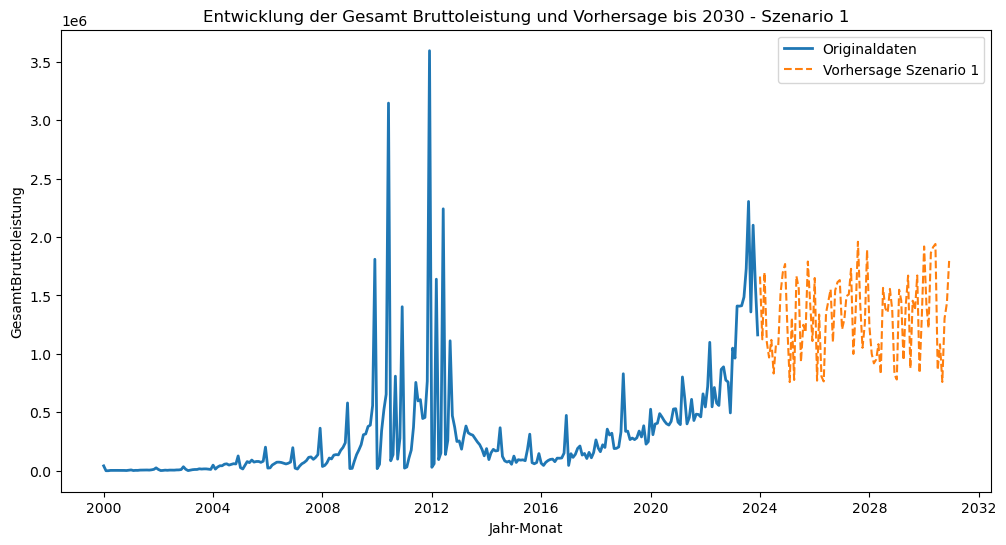

In [95]:
# zukünftige Monate
future_months = pd.date_range(start='2024-01-01', end='2030-12-01', freq='MS')
future_df = pd.DataFrame(index=future_months)

# Bedingungen für Szenario 1
future_df['Anzahl_Volleinspeisung'] = np.random.randint(1600, 4301, size=len(future_df))
future_df['Anzahl_Teileinspeisung'] = np.random.randint(37000, 112001, size=len(future_df))
future_df['Einspeiseverguetung'] = 7.65
future_df['Strompreis'] = 46.27
future_df['PV_Kosten_Euro_pro_kWp'] = 1250

# Vorhersagen für zukünftige Monate
y_pred_future_scenario1 = linear_reg_model_final.predict(future_df)
future_df['GesamtBruttoleistung_Predicted_Scenario1'] = y_pred_future_scenario1
combined_df_scenario1 = pd.concat([final_df, future_df])

plt.figure(figsize=(12, 6))
plt.plot(combined_df_scenario1.index, combined_df_scenario1['GesamtBruttoleistung'], label='Originaldaten', linewidth=2)
plt.plot(combined_df_scenario1.index, combined_df_scenario1['GesamtBruttoleistung_Predicted_Scenario1'], label='Vorhersage Szenario 1', linestyle='--')
plt.xlabel('Jahr-Monat')
plt.ylabel('GesamtBruttoleistung')
plt.title('Entwicklung der Gesamt Bruttoleistung und Vorhersage bis 2030 - Szenario 1')
plt.legend()
plt.show()

In [96]:
predictions_scenario1_df = pd.DataFrame(index=future_df.index)
predictions_scenario1_df['GesamtBruttoleistung_Predicted_Scenario1'] = y_pred_future_scenario1
#predictions_scenario1_df

**Simulations-Problem:**   
Während die Prädiktoren Einspeiseverguetung, Strompreis und PV_Kosten_Euro_pro_kWp direkt auf die Zielgröße GesamtBruttoleistung einwirken und im Rahmen einer Simulation auf beliebige Werte festgeschrieben werden können, hängen Anzahl_Volleinspeisung und Anzahl_Teileinspeisung in ihrer Höhe unmittelbar mit der Zielvariable zusammen. Die Anzahl der Anlagen sagt noch nichts über die installierte Leistung aus, aber mehr Anlagen bedeuten tendenziell eine höhere GesamtBruttoleistung. 

Insofern kann ich im Rahmen einer Simulation keinen sinnvollen Wertebereich Anzahl_Volleinspeisung und Anzahl_Teileinspeisung festlegen. Die Variablen müssen für die Simulation aus dem Modell entfernt werden.

In [97]:
model_sim = smf.ols(formula="GesamtBruttoleistung ~ Einspeiseverguetung + Strompreis + EEG_Umlage + PV_Kosten_Euro_pro_kWp", data=timeseries_df)
results_sim = model_sim.fit()
print(results_sim.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.418
Model:                              OLS   Adj. R-squared:                  0.410
Method:                   Least Squares   F-statistic:                     50.80
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):           3.34e-32
Time:                          10:42:36   Log-Likelihood:                -4089.3
No. Observations:                   288   AIC:                             8189.
Df Residuals:                       283   BIC:                             8207.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [98]:
model_sim2 = smf.ols(formula="GesamtBruttoleistung ~  Strompreis + EEG_Umlage + PV_Kosten_Euro_pro_kWp", data=timeseries_df)
results_sim2 = model_sim2.fit()
print(results_sim2.summary())

                             OLS Regression Results                             
Dep. Variable:     GesamtBruttoleistung   R-squared:                       0.418
Model:                              OLS   Adj. R-squared:                  0.411
Method:                   Least Squares   F-statistic:                     67.87
Date:                  Sun, 21 Apr 2024   Prob (F-statistic):           4.03e-33
Time:                          10:42:36   Log-Likelihood:                -4089.4
No. Observations:                   288   AIC:                             8187.
Df Residuals:                       284   BIC:                             8201.
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercep

In [99]:
# Verbindung zur Datenbank trennen
con.close()